# Project: TDS Virtual TA Requirement Checklist
- [X] Scrape "TDS Discourse posts with content from 1 Jan 2025 - 14 Apr 2025."
- [X] Scrape "Course content with content for TDS Jan 2025 as on 15 Apr 2025."


## Session handling
| Step | Description | Screenshot |
| --- | --- | --- |
| 1 | Inorder to update the cookies and user agents, I have used below script. <br> It is important to note that I have acquired the intial cookies together with request headers manually <br> I have stored those informations in the form of dictionaries in the files headers.json and cookies.json before running below script. <br> One more functionality i have added to the script is to rotate User-Agent to avoid any blocking of sessions from the server. <br> since the cookies contains confidential informations, i have added both the file names in `.gitignore`, <br> therefore any subsequesnt running from outside of my enviornment need this files added manually | 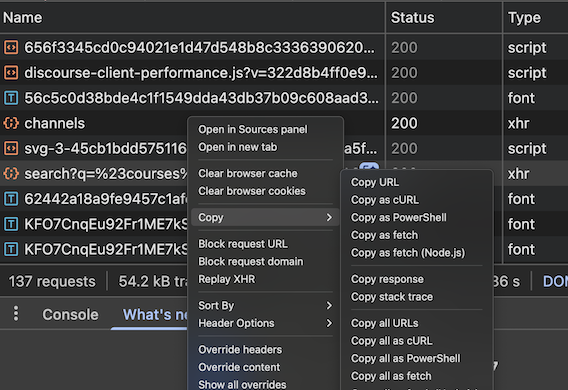 |

In [69]:
import requests
import json
import random
import os

USER_AGENTS = [
    # Popular desktop UAs
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 Chrome/114.0 Safari/537.36",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 Chrome/113.0 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 Version/14.0 Safari/605.1.15",
    "Mozilla/5.0 (X11; Linux aarch64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Safari/537.36 CrKey/1.54.250320"
]

def get_discourse_session(url: str = "https://discourse.onlinedegree.iitm.ac.in/search?q=%23courses%3Atds-kb%20after%3A2024-12-31%20before%3A2025-03-15&page=1"):
    session = requests.Session()
    headers = {}
    cookies = {}

    try:
        if os.path.exists("headers.json"):
            with open("headers.json") as f:
                headers = json.load(f)

        if os.path.exists("cookies.json"):
            with open("cookies.json") as f:
                cookies = json.load(f)

        headers["referer"] = url
        # Make request. Disables the certificate verification as i am getting a lot of failures around this
        response = session.get(url, verify=False, headers=headers, cookies=cookies)
        print(response)

        if response.status_code != 200:
            print("Error:", response.status_code)
            return {"error": "Failed to retrieve data"}

        return response.json()
    
    except requests.RequestException as e:
        print("Request error:", e)
        return {"error": str(e)}
    
    except json.JSONDecodeError as e:
        print("Failed to parse JSON file:", e)
        return {"error": "Invalid JSON in headers or cookies"}
    
    except Exception as e:
        print("Unexpected error:", e)
        return {"error": str(e)}

    finally:
        
        # Save cookies and headers
        cookies["_t"] = session.cookies.get("_t")
        if cookies["_t"]:
            with open("cookies.json", "w") as f:
                json.dump(cookies, f)

        headers["user-agent"] = random.choice(USER_AGENTS)
        headers["x-csrf-token"] = response.request.headers.get("x-csrf-token")
        if headers["x-csrf-token"]:
            with open("headers.json", "w") as f:
                json.dump(headers, f)

        session.close()



In [ ]:
# Test the session creation and closure functionality
print(get_discourse_session())
print(get_discourse_session())
print(get_discourse_session())
print(get_discourse_session())

## Scrape Discourse data
| Step | Description | Screenshot |
| --- | --- | --- |
| 1 | As first step i have filtered the Topics/posts as in the attached screenshot | 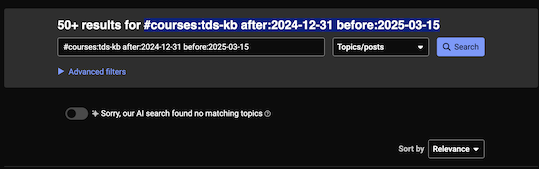 |
| 2 | `95` results as search result. As per the inspections in the Chrome dev tools, <br> found that there are two url navigations triggered as part of the Search result page loading. | https://discourse.onlinedegree.iitm.ac.in/search?q=%23courses%3Atds-kb%20after%3A2024-12-31%20before%3A2025-03-15&page=1 <br> https://discourse.onlinedegree.iitm.ac.in/search?q=%23courses%3Atds-kb%20after%3A2024-12-31%20before%3A2025-03-15&page=2 |
| 3 | Found a json object with this structure.  | 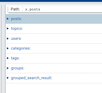 |

In [ ]:
import requests
from urllib.parse import urlencode

baseurl = "https://discourse.onlinedegree.iitm.ac.in/search"
params1 = {
    "q": "#courses:tds-kb after:2024-12-31 before:2025-03-15",
    "page": 1
}
params2 = {
    "q": "#courses:tds-kb after:2024-12-31 before:2025-03-15",
    "page": 2
}

def scrape_data(url, params):
    # Construct the full URL with query parameters
    full_url = f"{url}?{urlencode(params)}"

    return get_discourse_session(full_url)

p1 = scrape_data(baseurl, params1)
p2 = scrape_data(baseurl, params2)

## p1 and p2 have structure similar to below image
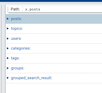

In [78]:
# Script to verify the json structure
import json

def print_json_structure(data, prefix=""):
    if isinstance(data, dict):
        for key, value in data.items():
            new_prefix = f"{prefix}.{key}" if prefix else key
            print(f"{new_prefix} : {type(value).__name__}")
            print_json_structure(value, new_prefix)
    elif isinstance(data, list):
        print(f"{prefix}[] : list of {type(data[0]).__name__}" if data else f"{prefix}[] : list")
        if data:
            print_json_structure(data[0], prefix + "[]")

In [ ]:
# Check structure
print_json_structure(p1)

In [ ]:
# Verify the results
print(p1)
print(p2)

In [74]:
# Verify the count of posts in each page
countp1 = 0
countp2 = 0
for post in p1['posts']:
    countp1 += 1
for post in p2['posts']:
    countp2 += 1

print(f"Page 1 has {countp1} posts.")
print(f"Page 2 has {countp2} posts.")

# Verify the types of the results
print(type(p1))
print(type(p2))

Page 1 has 50 posts.
Page 2 has 45 posts.
<class 'dict'>
<class 'dict'>


## Combine all posts
| Step | Description | Screenshot |
| --- | --- | --- |
| 1 | If we expand `posts` key further, it contains a list of posts with attched key values pairs. | 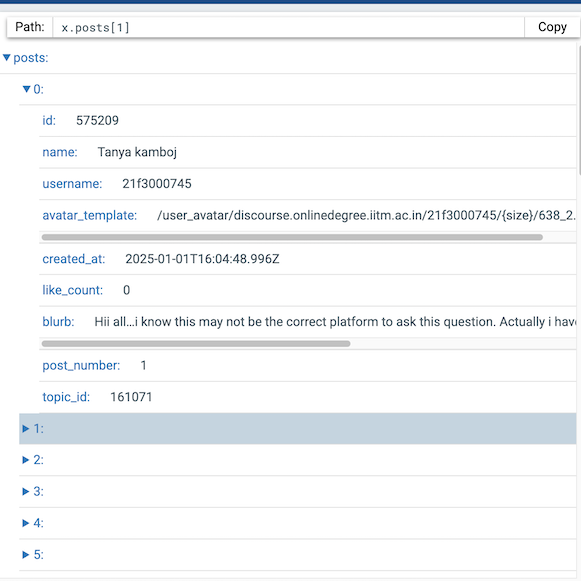 |
| 2 | Each post contains a post id and topic id, which probabably help to formulate the source urls. | Look above |
| 3 | In additin to that we have two seperate list of posts which we need to combine. | |


In [76]:
import json

merged = p1.copy()

for key, val in p2.items():
    if key == 'posts' and isinstance(val, list):
        # concatenate the two lists
        merged['posts'] = p1.get('posts', []) + val
    else:
        # for other keys, p2’s value wins
        merged[key] = val

json_data_str = json.dumps(merged, indent=4)


In [77]:
# Verifying after the merge the count of post is same as the sum of previous two post lists (50 + 45)
countmerged = 0
for post in merged['posts']:
    countmerged += 1

print(f"Merged data has {countmerged} posts.")

Merged data has 95 posts.


In [ ]:
# Verify structure
print_json_structure(merged)

#### Remove unnecessary keys from the data

In [82]:
keys_to_remove = [
    "topics",
    "users",
    "categories",
    "tags",
    "groups",
    "grouped_search_result"
]

json_data = json.loads(json_data_str)
json_data_filtered = {k: v for k, v in json_data.items() if k not in keys_to_remove}

json_data_filtered_json = json.dumps(json_data_filtered, indent=2)

In [83]:
print_json_structure(json_data_filtered)

posts : list
posts[] : list of dict
posts[].id : int
posts[].name : str
posts[].username : str
posts[].avatar_template : str
posts[].created_at : str
posts[].like_count : int
posts[].blurb : str
posts[].post_number : int
posts[].topic_id : int


#### I thought of creating a list of set (topic_id, post_id), individual posts contains too less informations to formulate answers for a query. The answers will be a symantic formulation of whole messages within a post. In such cases it is really hard to point to a single post as refernce url. Rather i choose to use topic URL.


In [88]:
list_topic_id = [entry["topic_id"] for entry in json_data_filtered["posts"]]

In [89]:
print(list_topic_id)

[161071, 163247, 166189, 169029, 169283, 169888, 164277, 168916, 169807, 169369, 168832, 168506, 169393, 169352, 166576, 169247, 99838, 168449, 169045, 168537, 168987, 168901, 168943, 168825, 141413, 168476, 166651, 168515, 168567, 168384, 168458, 168482, 168011, 168310, 168303, 168142, 165959, 168143, 168057, 168017, 167878, 166816, 167679, 167344, 167415, 167471, 167410, 167699, 167172, 164214, 166891, 167072, 166738, 166647, 166634, 166498, 165416, 165433, 161120, 166303, 166357, 166349, 165687, 166100, 165396, 165922, 165830, 165746, 165593, 23335, 163158, 165142, 164869, 164737, 164462, 164460, 164291, 164147, 163765, 164205, 164089, 163381, 163241, 163224, 163147, 161072, 163144, 162425, 161214, 160251, 160773, 161083, 169456, 166866, 166593]


In [90]:
len(list_topic_id)

95

#### Traverse through each topic URL and record those data. Structure of the response json contains this structure.
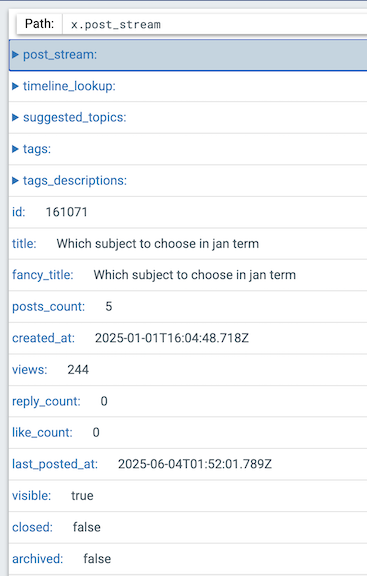

In [92]:
def scrape_topic_data(topic_id):
    full_url = f"https://discourse.onlinedegree.iitm.ac.in/t/{topic_id}.json"

    return get_discourse_session(full_url)


#### Image understanding using gemini models. Need to set either GOOGLE_API_KEY or GEMINI_API_KEY as environemnte variable

In [202]:
from google import genai
from google.genai import types
from requests.exceptions import RequestException
import os

client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])

def understand_image(image_path):
    print("Image:", image_path)
    try:
        image_bytes = requests.get(image_path).content
        content_type = ""
        head = requests.head(image_path, timeout=5)
        content_type = head.headers.get('Content-Type')
        image = types.Part.from_bytes(
            data=image_bytes,mime_type=content_type
        )
        response = client.models.generate_content(
            model="gemini-2.0-flash",
            contents=[image, "What is in this image?"],
        )
        return response.text
    
    except RequestException as e:
        print(f"[Warning] Failed to download image header: {e}")
        return None

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


#### Testing topic data scraping

In [95]:
from bs4 import BeautifulSoup

topic_data = scrape_topic_data(161120)
question = 0
for post in topic_data.get("post_stream", {}).get("posts", []):
    r = post.get('cooked', '<p>No content available<p>')
    soup = BeautifulSoup(r, 'html.parser')

    print(topic_data.get("slug"))
    print(topic_data.get("title"))
    if question == 0:
        print(f"Question: {soup.get_text(separator=' ',strip=True)}\n")
    else:
        print(f"Response {question}: {soup.get_text(separator=' ',strip=True)}\n")
    images = soup.find_all('img')
    if images:
        for img in images:
            if img.get('src'):
                if "slight_smile.png" not in img.get('src'):
                    print(understand_image(img.get('src')))
    question += 1

/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
ga2-deployment-tools-discussion-thread-tds-jan-2025
GA2 - Deployment Tools - Discussion Thread [TDS Jan 2025]
Question: Please post any questions related to Graded Assignment 2 - Deployment Tools . Important Instruction Please use markdown code formatting (fenced code blocks) when sharing code in Discourse posts. This makes the code much easier to read and differentiate from non-code text. It also makes it easier for people to copy code snippets and run it themselves. Visit this link for more details: Extended Syntax | Markdown Guide . A friendly suggestion: kindly go through Discourse Docs ! Deadline: Sunday, February 2, 2025 6:29 PM @carlton @Jivraj

ga2-deployment-tools-discussion-thread-tds-jan-2025
GA2 - Deployment Tools - Discussion Thread [TDS Jan 2025]
Response 1: 

ga2-deployment-tools-discussion-thread-tds-jan-2025
GA2 - Deployment Tools - Discussion Thread [TDS Jan 2025]
Response 2: Screenshot 2025-01-12 223630 1727×195 27.1 KB i have included the email addr

#### Testing the delay setting while scraping

In [96]:

from datetime import datetime, timedelta
import time

now_local = time.time()
print(now_local)
time.sleep(5)
print(time.time() - now_local)

1750020999.1067069
5.005321025848389


In [97]:
if all(sub not in "https://emoji.discourse-cdn.com/google/clap.png?v=12" for sub in ["slight_smile.png","emoji"]):
    print(1)

In [98]:
from bs4 import BeautifulSoup
import time

now_local = 5

for topic_id in list_topic_id:
    print(topic_id,"\n")
    try:
        with open(f'discourse/{topic_id}.txt', 'x', encoding='utf-8') as f:
            topic_data = scrape_topic_data(topic_id)
            if "error" not in topic_data:
                print(f"Title: {topic_data.get('title' , ' ')}\n")
                f.write(f"Title: {topic_data.get('title' , ' ')}\n")
                print(f"source_url: https://discourse.onlinedegree.iitm.ac.in/t/{topic_data.get('slug' , '')}/{topic_id}\n\n")
                f.write(f"source_url: https://discourse.onlinedegree.iitm.ac.in/t/{topic_data.get('slug' , '')}/{topic_id}\n\n")
                question = 0
                for post in topic_data.get("post_stream", {}).get("posts", []):
                    r = post.get('cooked', '<p>No content available<p>')
                    soup = BeautifulSoup(r, 'html.parser')
                    if question == 0:
                        f.write(f"Question: {soup.get_text(separator=' ',strip=True)}\n")
                    else:
                        f.write(f"Response {question}: {soup.get_text(separator=' ',strip=True)}\n")
                    
                    f.write("\n")
                    images = soup.find_all('img')

                    if images:
                        for img in images:
                            if img.get('src'):
                                if all(sub not in img.get('src') for sub in ["slight_smile.png","emoji","avatar","favicon","logo"]):
                                    if (time.time() - now_local) < 5:
                                        time.sleep(5)
                                    now_local = time.time()
                                    image_def = understand_image(img.get('src'))
                                    if image_def:
                                        f.write(f"Image explanation: {image_def}\n")
                    question += 1
            else:
                print(f"Failed to retrieve data for topic ID {topic_id}: {topic_data['error']}")
    except FileExistsError:
        print(f"File '{topic_id}.txt' already exists; will not overwrite.") 

161071 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Which subject to choose in jan term

source_url: https://discourse.onlinedegree.iitm.ac.in/t/which-subject-to-choose-in-jan-term/161071


163247 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: GA3 - Large Language Models - Discussion Thread [TDS Jan 2025]

source_url: https://discourse.onlinedegree.iitm.ac.in/t/ga3-large-language-models-discussion-thread-tds-jan-2025/163247


166189 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Tds: assignment is not submitting

source_url: https://discourse.onlinedegree.iitm.ac.in/t/tds-assignment-is-not-submitting/166189


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/d/5/d51f4ef2faa1d935371f7b95e9d49a85435b481d_2_690x388.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/5/1/51fd5a5ad1f47e528360f19eb4fcaaccc3cee612.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/2/9/29b6332cf814991a2cdae74355e67478bcc57c57_2_690x356.png
169029 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Project 2 - TDS Solver - Discussion Thread

source_url: https://discourse.onlinedegree.iitm.ac.in/t/project-2-tds-solver-discussion-thread/169029


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/5/3/53bf199bb686fb99cd7b6974c6971326fb8c8482.png
169283 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Graded assignment 6

source_url: https://discourse.onlinedegree.iitm.ac.in/t/graded-assignment-6/169283


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/a/6/a6fa9a2e601c94da84cbd25c406235d1009b204c.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/5/1/51b03d00c3e962e6c4fc7fc64930a23e82500006.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/b/d/bd0ea5ffab782a7d6bcc8b1cde7ba7f385b85630_2_690x131.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/f/c/fccc54e8cff0595d93b1c5185ce0a10343849b04_2_690x190.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/9/6/9656b143021a1b4baf78510b1ba05ae9cbd6ca9b_2_690x197.png
169888 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: GA7 - Data Visualisation - Discussion Thread [TDS Jan 2025]

source_url: https://discourse.onlinedegree.iitm.ac.in/t/ga7-data-visualisation-discussion-thread-tds-jan-2025/169888


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/a/6/a68861da691806bfec99dc5a1430e57440f508c6_2_690x325.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/f/2/f29503cb82bdf0e5bfb45009597ef56609982c17_2_690x444.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/a/6/a6fdec02b5239ef02c5198e250c8a2d6eb007b82.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/a/1/a121b005d9edc2469571d46018f450882b3fcb81.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/1/a/1a6b77faf6850d0af1282a8b367f2daa95496baa.png
164277 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Project 1 - LLM-based Automation Agent - Discussion Thread [TDS Jan 2025]

source_url: https://discourse.onlinedegree.iitm.ac.in/t/project-1-llm-based-automation-agent-discussion-thread-tds-jan-2025/164277


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/2/0/20410aa56e88be04883b6f3feca5010089afe276_2_690x67.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/4/8/488e23f9ea65d35c5ba806fab09f4b5934ed2ed4_2_500x500.png
168916 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Project 1 tds score not showing i

source_url: https://discourse.onlinedegree.iitm.ac.in/t/project-1-tds-score-not-showing-i/168916


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/c/2/c2b3cf40d7c5b4b3540661aadd70ad58532b671b_2_690x388.jpeg
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/5/0/5044bf96daf786a1fcd86f30ea3a94dc80b62949_2_690x175.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/c/2/c2b3cf40d7c5b4b3540661aadd70ad58532b671b_2_690x388.jpeg
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/a/e/ae725715cb22440a81895770878ed664acb2da80_2_545x500.jpeg
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/a/e/ae725715cb22440a81895770878ed664acb2da80_2_545x500.jpeg
169807 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Clarification on Passing Criteria for TDS – January 2025 Term

source_url: https://discourse.onlinedegree.iitm.ac.in/t/clarification-on-passing-criteria-for-tds-january-2025-term/169807


169369 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Programming Quiz 1 in Student Dashboard (label for ROE scores) - showing absent or incorrect

source_url: https://discourse.onlinedegree.iitm.ac.in/t/programming-quiz-1-in-student-dashboard-label-for-roe-scores-showing-absent-or-incorrect/169369


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/6/3/63cef97db246dc78e24de98165728e4f0e9eb07d.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/4/4/445af6080ca00a4985804706967af87746caddf8.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/5/6/56bc2e79d98c8d3790a4ab9e3a44829f71b093c2_2_523x500.jpeg
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/6/f/6fa4f2dcddaef659825a3c998b024cfe85c5fda2.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/3/b/3b148d32b8cb1b3f39f71b5602d5047d718102c2_2_445x500.jpeg
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/2/b/2b05d50f575

/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Remote Online Exam [TDS Jan 2025]

source_url: https://discourse.onlinedegree.iitm.ac.in/t/remote-online-exam-tds-jan-2025/168832


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/1/d/1d924906c7ec5da0a28f312565842402743638be_2_690x388.png
168506 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Revised dates [TDS Jan 2025]

source_url: https://discourse.onlinedegree.iitm.ac.in/t/revised-dates-tds-jan-2025/168506


169393 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Thursday live session

source_url: https://discourse.onlinedegree.iitm.ac.in/t/thursday-live-session/169393


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/a/1/a1ba40c716051f486e2fb3eaae126c6121075f69.jpeg
169352 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Solve this roe mistake pls

source_url: https://discourse.onlinedegree.iitm.ac.in/t/solve-this-roe-mistake-pls/169352


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/b/8/b8bcbf8009364152380ffbd0508ead5cc0700c2c_2_690x431.png
166576 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: GA5 - Data Preparation - Discussion Thread [TDS Jan 2025]

source_url: https://discourse.onlinedegree.iitm.ac.in/t/ga5-data-preparation-discussion-thread-tds-jan-2025/166576


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/2/7/2760b6a798c8d242c17b057acd6cf686ab1bc2fe_2_690x296.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/d/0/d00d9bc84126cc644cd4a75cea1db8ab4d4bf0a6_2_690x277.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/0/2/02dbdb81b1a8befd5172bf0cb16e25c59b8038b2.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/9/7/979374c3f5507f373bae753017ab4235a420e1b2_2_528x499.jpeg
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/7/5/754b8cb67790be42f3cb034ef920509a08820ad8_2_690x473.jpeg
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/b/f/bf1a8f36cc99be3a4d7b2d5552a90c431b227a85.png
Image: https://e

/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Disparity in TDS GA 5 scores

source_url: https://discourse.onlinedegree.iitm.ac.in/t/disparity-in-tds-ga-5-scores/169247


99838 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: What's the actual purpose of impossible ROE exam?

source_url: https://discourse.onlinedegree.iitm.ac.in/t/whats-the-actual-purpose-of-impossible-roe-exam/99838


168449 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Mock ROE 1, 2, 3, 4 [TDS Jan 2025]

source_url: https://discourse.onlinedegree.iitm.ac.in/t/mock-roe-1-2-3-4-tds-jan-2025/168449


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/e/4/e4bbf44d7e5f8f2c5eb56b7f3fef215aebde55b3.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/d/6/d6093c2bb2ffb40a728365c2ceda26a216a2c61a_2_690x362.jpeg
169045 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Project 2 - TDS Solver - Shared Data Pool

source_url: https://discourse.onlinedegree.iitm.ac.in/t/project-2-tds-solver-shared-data-pool/169045


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/a/2/a2ca53960e1ef9d9566dd1648096df09332e6310.gif
168537 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: ROE timing overlaps with Java OPPE

source_url: https://discourse.onlinedegree.iitm.ac.in/t/roe-timing-overlaps-with-java-oppe/168537


168987 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Unable to attend the ROE

source_url: https://discourse.onlinedegree.iitm.ac.in/t/unable-to-attend-the-roe/168987


168901 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: ROE Common Snippets Repo Feb 2025

source_url: https://discourse.onlinedegree.iitm.ac.in/t/roe-common-snippets-repo-feb-2025/168901


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/4/7/4780e9efee3fee9a734598aa75a48693828aadb0_2_690x344.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/6/4/64c7cdf7626ee50fdc262143cf9484c83a546333.png
168943 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Solving ROE Realtime

source_url: https://discourse.onlinedegree.iitm.ac.in/t/solving-roe-realtime/168943


168825 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Not recieved the roe link mail

source_url: https://discourse.onlinedegree.iitm.ac.in/t/not-recieved-the-roe-link-mail/168825


141413 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Is it fair to consider 20% weightage of such exam which is impossible to solve in given time (i.e. ROE)

source_url: https://discourse.onlinedegree.iitm.ac.in/t/is-it-fair-to-consider-20-weightage-of-such-exam-which-is-impossible-to-solve-in-given-time-i-e-roe/141413


168476 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Concerns Regarding TDS Course Difficulty and Grading Fairness

source_url: https://discourse.onlinedegree.iitm.ac.in/t/concerns-regarding-tds-course-difficulty-and-grading-fairness/168476


166651 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Tds w4- q3

source_url: https://discourse.onlinedegree.iitm.ac.in/t/tds-w4-q3/166651


168515 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Opening previous ga just for practise

source_url: https://discourse.onlinedegree.iitm.ac.in/t/opening-previous-ga-just-for-practise/168515


168567 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Create a Question solving groups for ROE

source_url: https://discourse.onlinedegree.iitm.ac.in/t/create-a-question-solving-groups-for-roe/168567


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/0/6/069dfcbf1c98ea2160a1c33abb79107eaf6f2b36.png
168384 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Clarification regarding Mock ROE Timings

source_url: https://discourse.onlinedegree.iitm.ac.in/t/clarification-regarding-mock-roe-timings/168384


168458 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Tds roe exam date shift

source_url: https://discourse.onlinedegree.iitm.ac.in/t/tds-roe-exam-date-shift/168458


168482 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: TDS Module 6

source_url: https://discourse.onlinedegree.iitm.ac.in/t/tds-module-6/168482


168011 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Q3, GA5 not accepting right answer

source_url: https://discourse.onlinedegree.iitm.ac.in/t/q3-ga5-not-accepting-right-answer/168011


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/1/5/158680f0acc5ef430efd87e8a1cc59a78e6d5e07.png
168310 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Request for a functionality to revise the GAs of TDS

source_url: https://discourse.onlinedegree.iitm.ac.in/t/request-for-a-functionality-to-revise-the-gas-of-tds/168310


168303 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Project 2 and Week 6 assignment

source_url: https://discourse.onlinedegree.iitm.ac.in/t/project-2-and-week-6-assignment/168303


168142 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: ROE instructions request

source_url: https://discourse.onlinedegree.iitm.ac.in/t/roe-instructions-request/168142


165959 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: GA4 - Data Sourcing - Discussion Thread [TDS Jan 2025]

source_url: https://discourse.onlinedegree.iitm.ac.in/t/ga4-data-sourcing-discussion-thread-tds-jan-2025/165959


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/0/0/0007976ca3410205e4fa403a71b9a1ac79bf5192.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/6/9/699d94f19d189a93a67fb813a5eeed3d1f73abf3_2_690x388.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/1/b/1b7f2ec2868a09d8b4ed3fc50afa02f8416dad93_2_690x143.png
168143 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: My score are still not updated

source_url: https://discourse.onlinedegree.iitm.ac.in/t/my-score-are-still-not-updated/168143


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/c/5/c554924d186f2c50faa5c62af45129a46b3ef06c_2_690x424.png
168057 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: QUESTION 9 of TDS WEEK 5 GA

source_url: https://discourse.onlinedegree.iitm.ac.in/t/question-9-of-tds-week-5-ga/168057


168017 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: GA5 Score Not Reflecting in The Page After Deadline

source_url: https://discourse.onlinedegree.iitm.ac.in/t/ga5-score-not-reflecting-in-the-page-after-deadline/168017


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/e/9/e9585e072dfc3561e03c611c02e5b5e283f3f1be_2_690x448.png
167878 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: About TDS Course

source_url: https://discourse.onlinedegree.iitm.ac.in/t/about-tds-course/167878


166816 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Graded Assignments Dashboard Scores Incorrect/Missing

source_url: https://discourse.onlinedegree.iitm.ac.in/t/graded-assignments-dashboard-scores-incorrect-missing/166816


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/5/6/56b130af1cc28926192b9915e2ea49a471168b8e_2_690x310.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/1/2/12633c3acc823f927ca57b5f3c0efadcf89de1b0_2_690x302.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/7/6/7659b9ba3bf327fd5d15ca20d77836ec62770a9f_2_690x348.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/a/d/ade36e6af66c8f0677eab16962a78c0d1211e7dc_2_690x320.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/1/2/1283504bdf9a3f1f7d5ff5d2154d0f5695fe403b.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/1/9/1963cbcb144b5c204546563728943940654eaeaf.png
Image: https://europ

/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Inconsistent information in the Grading Document and the website

source_url: https://discourse.onlinedegree.iitm.ac.in/t/inconsistent-information-in-the-grading-document-and-the-website/167679


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/d/6/d6f1b7044757c29a9ff64c6d9f38afcb1829c308_2_635x500.png
167344 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Project 1 - Casual banter

source_url: https://discourse.onlinedegree.iitm.ac.in/t/project-1-casual-banter/167344


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/7/7/7742d688f4b033b15ac1a4af0c1f2eda19c31093.jpeg
167415 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: IMPORTANT: Dockerfile submitted as dockerfile rest everything is working fine

source_url: https://discourse.onlinedegree.iitm.ac.in/t/important-dockerfile-submitted-as-dockerfile-rest-everything-is-working-fine/167415


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/b/f/bf69a3cdef0ecdaeb2a38ccd8fa511d1f41a4312.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/1/a/1a5f2ea044383efcb5d248ddb487665e9e65957d_2_690x170.png
167471 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Project 1 Submission Marked as FAIL Despite Having Dockerfile & Image

source_url: https://discourse.onlinedegree.iitm.ac.in/t/project-1-submission-marked-as-fail-despite-having-dockerfile-image/167471


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/6/a/6a4a28aa638840e8d2e4dbf246ca235fd41e5ccb.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/d/1/d14c53cce65e7ac7f679de75bba301f3ee23f1f0.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/6/a/6a4a28aa638840e8d2e4dbf246ca235fd41e5ccb.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/1/a/1a5f2ea044383efcb5d248ddb487665e9e65957d_2_690x170.png
167410 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Request to Consider My Last Submission for TDS Project 1

source_url: https://discourse.onlinedegree.iitm.ac.in/t/request-to-consider-my-last-submission-for-tds-project-1/167410


167699 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Just some background test

source_url: https://discourse.onlinedegree.iitm.ac.in/t/just-some-background-test/167699


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/7/7/7742d688f4b033b15ac1a4af0c1f2eda19c31093.jpeg
167172 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Regarding project1 for file not detecting after sending post request

source_url: https://discourse.onlinedegree.iitm.ac.in/t/regarding-project1-for-file-not-detecting-after-sending-post-request/167172


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/2/5/255972d284f089960091b482f45a9c8f83919195_2_690x446.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/3/c/3c786f00a8e4f37db2c31ff21edffb3e68396b59_2_690x411.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/3/8/38616e70dfbf04366baf4c5690da45032982aa4f_2_534x500.png
164214 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: TDS Project 1 release information required

source_url: https://discourse.onlinedegree.iitm.ac.in/t/tds-project-1-release-information-required/164214


166891 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Regarding Github Mail For Project

source_url: https://discourse.onlinedegree.iitm.ac.in/t/regarding-github-mail-for-project/166891


167072 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Sudo permission needed to create data folder in root?

source_url: https://discourse.onlinedegree.iitm.ac.in/t/sudo-permission-needed-to-create-data-folder-in-root/167072


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/f/5/f51040627e050b955bb243c23f1f660da36b73ae_2_690x70.png
166738 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Project structure

source_url: https://discourse.onlinedegree.iitm.ac.in/t/project-structure/166738


166647 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: I have doubt in Q10

source_url: https://discourse.onlinedegree.iitm.ac.in/t/i-have-doubt-in-q10/166647


166634 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Doubt in GA4 Q7

source_url: https://discourse.onlinedegree.iitm.ac.in/t/doubt-in-ga4-q7/166634


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/9/2/92ea4dcea08bee572e3014e2643e84c2d1ad1265_2_666x500.jpeg
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/0/d/0d4f66d2d15a90c43877612db24b4fc030d6b439_2_666x500.jpeg
166498 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Chat GPT new release

source_url: https://discourse.onlinedegree.iitm.ac.in/t/chat-gpt-new-release/166498


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/0/b/0b553dbb1337d12e5a557065768b503180d8d762_2_690x363.jpeg
165416 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Where can i find the TDS GA1 after the submission date has passed?

source_url: https://discourse.onlinedegree.iitm.ac.in/t/where-can-i-find-the-tds-ga1-after-the-submission-date-has-passed/165416


165433 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Questions closed (GA)

source_url: https://discourse.onlinedegree.iitm.ac.in/t/questions-closed-ga/165433


161120 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: GA2 - Deployment Tools - Discussion Thread [TDS Jan 2025]

source_url: https://discourse.onlinedegree.iitm.ac.in/t/ga2-deployment-tools-discussion-thread-tds-jan-2025/161120


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/f/2/f2485af8a009f815219a3df4bbdf15db1322608e_2_690x77.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/e/f/ef0c6289076549898612976667c10de3886cc953_2_690x65.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/1/b/1b67fc201449a012745d92b7efdcf9e92fc7a35b_2_690x344.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/2/4/243cab0b6d8a65099dfe8b13b242dd816a4f3205_2_690x431.jpeg
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/e/2/e2d34a628bc87d88e8e28cbb9a08254c16f6ba76_2_690x318.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/d/7/d7bcf7a2f709561b98fa8bde031ab5d1e81a4a0d.png
166303 


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: LLM what rocket science going on here

source_url: https://discourse.onlinedegree.iitm.ac.in/t/llm-what-rocket-science-going-on-here/166303


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/5/f/5f761086e44617c54e405c03db45772d8428e8df.jpeg
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/c/3/c37c79aa38f5d6c672b5a13b4f99a012a7e5da74.jpeg
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/6/f/6f939856a1a40a564cc355f6fd4a217178902967.jpeg
166357 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Doubts in Q7, Q8

source_url: https://discourse.onlinedegree.iitm.ac.in/t/doubts-in-q7-q8/166357


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/d/7/d7e9677b9a8d204c98e6008ef57a884177301fad_2_690x366.png
166349 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Reattempt Graded Assignment after deadline

source_url: https://discourse.onlinedegree.iitm.ac.in/t/reattempt-graded-assignment-after-deadline/166349


165687 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Meet with Anand (TDS Faculty), Wed 5 Feb, 10:30 am - 2:30 pm

source_url: https://discourse.onlinedegree.iitm.ac.in/t/meet-with-anand-tds-faculty-wed-5-feb-10-30-am-2-30-pm/165687


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/3/c/3c4a546e7bae08a17f873f828185df45aa57f717_2_690x451.png
166100 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Access to Notebooks

source_url: https://discourse.onlinedegree.iitm.ac.in/t/access-to-notebooks/166100


165396 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Graded assignment 1 - Submission not shown

source_url: https://discourse.onlinedegree.iitm.ac.in/t/graded-assignment-1-submission-not-shown/165396


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/0/2/02d5c238cb5d933e537ef2c236c52132ffcfa333_2_690x271.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/7/6/76ef23eb9260d3e215c3ebb09afd1dc74baae294_2_690x385.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/5/e/5e679a390c2c28452082014cf26d1200083f2ec4_2_690x374.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/0/6/06e671d604773ce8d8708608a4ec889ac8d28621_2_690x436.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/2/4/248ba6ca7a631c6575fff25f803101db067308f7_2_690x322.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/a/1/a19db9b2ea7ddf2313099689f75e46080efce62e_2_617x500.png
Image: https://europe1

/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Best Practices for Virtual Environments and Dependency Management in Python

source_url: https://discourse.onlinedegree.iitm.ac.in/t/best-practices-for-virtual-environments-and-dependency-management-in-python/165922


165830 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Live Session Agenda - 30/01/2025

source_url: https://discourse.onlinedegree.iitm.ac.in/t/live-session-agenda-30-01-2025/165830


165746 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Course drop

source_url: https://discourse.onlinedegree.iitm.ac.in/t/course-drop/165746


165593 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Live sessions regarding Project 1

source_url: https://discourse.onlinedegree.iitm.ac.in/t/live-sessions-regarding-project-1/165593


23335 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: About the Tools in Data Science category

source_url: https://discourse.onlinedegree.iitm.ac.in/t/about-the-tools-in-data-science-category/23335


163158 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Tds jan 2025 calender accesss and video lecture access in portal

source_url: https://discourse.onlinedegree.iitm.ac.in/t/tds-jan-2025-calender-accesss-and-video-lecture-access-in-portal/163158


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/7/8/782e69e2b13a88c1e2dd54a2cb28d8778828c041_2_690x413.jpeg
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/b/7/b7c29496f7b2a20dc259fb7176a17e75513d1f20_2_690x262.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/d/f/dfbb3776487be8186e362fb0f11ec940f82939b0_2_690x365.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/f/3/f35f45e7fddf76617cfba3d572f348f225c6978f.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/f/6/f6b27ff9eac7292e61489e8e695d2cafc433ad86_2_690x376.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/c/2/c27c6f5e0febea8fee5c5ae9668eadf3bcdb8149_

/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: GA2 deadline

source_url: https://discourse.onlinedegree.iitm.ac.in/t/ga2-deadline/165142


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/f/6/f678f69ef208b0d9fed9278ebefe295284766035_2_690x188.png
164869 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Agenda for Today's Live Session [Flask Tutorial]

source_url: https://discourse.onlinedegree.iitm.ac.in/t/agenda-for-todays-live-session-flask-tutorial/164869


164737 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Drop Course window for TDS

source_url: https://discourse.onlinedegree.iitm.ac.in/t/drop-course-window-for-tds/164737


164462 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: TDS - Assignment week 2

source_url: https://discourse.onlinedegree.iitm.ac.in/t/tds-assignment-week-2/164462


164460 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Agenda for Today's(21/01/2025) session

source_url: https://discourse.onlinedegree.iitm.ac.in/t/agenda-for-todays-21-01-2025-session/164460


164291 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Regarding droping from TDS

source_url: https://discourse.onlinedegree.iitm.ac.in/t/regarding-droping-from-tds/164291


164147 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Issues In TDS And Replacement with another course

source_url: https://discourse.onlinedegree.iitm.ac.in/t/issues-in-tds-and-replacement-with-another-course/164147


163765 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Score keeps resetting to 0

source_url: https://discourse.onlinedegree.iitm.ac.in/t/score-keeps-resetting-to-0/163765


164205 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Need Clarity

source_url: https://discourse.onlinedegree.iitm.ac.in/t/need-clarity/164205


164089 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: TA Sessions youtube links

source_url: https://discourse.onlinedegree.iitm.ac.in/t/ta-sessions-youtube-links/164089


163381 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Need friends

source_url: https://discourse.onlinedegree.iitm.ac.in/t/need-friends/163381


163241 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Regarding EXTRA MATERIAL/INFORMATION/RESOURCES for the upcoming project

source_url: https://discourse.onlinedegree.iitm.ac.in/t/regarding-extra-material-information-resources-for-the-upcoming-project/163241


163224 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Answers are not getting saved

source_url: https://discourse.onlinedegree.iitm.ac.in/t/answers-are-not-getting-saved/163224


163147 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: TDS iitm certified books

source_url: https://discourse.onlinedegree.iitm.ac.in/t/tds-iitm-certified-books/163147


161072 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Can I take the end-term exam without submitting assignments if I missed it due to an emergency?

source_url: https://discourse.onlinedegree.iitm.ac.in/t/can-i-take-the-end-term-exam-without-submitting-assignments-if-i-missed-it-due-to-an-emergency/161072


163144 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Way of conduction of exam

source_url: https://discourse.onlinedegree.iitm.ac.in/t/way-of-conduction-of-exam/163144


162425 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: TDS calendar link not found

source_url: https://discourse.onlinedegree.iitm.ac.in/t/tds-calendar-link-not-found/162425


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/b/6/b690d26af607c7a3a2af2f41a6e89d323ac7510c_2_689x364.png
161214 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Contribute to My Open-Source LLM Classroom Assignment Evaluator

source_url: https://discourse.onlinedegree.iitm.ac.in/t/contribute-to-my-open-source-llm-classroom-assignment-evaluator/161214


160251 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Reflecting status as "Absent" in TDS Roe on Dashboard

source_url: https://discourse.onlinedegree.iitm.ac.in/t/reflecting-status-as-absent-in-tds-roe-on-dashboard/160251


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/f/d/fdd8977eb016b9e2e91e5373546b1f2a6c5dc914.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/a/1/a1208d20001cc2c1babcd3b552f732dedf3e7b76_2_393x500.png
160773 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Where are my bonus marks?

source_url: https://discourse.onlinedegree.iitm.ac.in/t/where-are-my-bonus-marks/160773


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/3/a/3a05a7da6e725a61258f82a87a3c80a07ce20d15_2_264x500.png
161083 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: GA1 - Development Tools - Discussion Thread [TDS Jan 2025]

source_url: https://discourse.onlinedegree.iitm.ac.in/t/ga1-development-tools-discussion-thread-tds-jan-2025/161083


Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/f/8/f8af7c6e2fe001c8bf000605b52c903e1b0e6fe1.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/7/b/7be5e1eb5ea66bf30d3a3ebb32850f99e077bcb5_2_690x333.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/f/8/f8af7c6e2fe001c8bf000605b52c903e1b0e6fe1.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/f/6/f608128ef0d30f88223b247f1c02394c91943015_2_690x85.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/optimized/3X/7/7/7762e0cad9334545b58855946414228e23ffccae_2_690x431.png
Image: https://europe1.discourse-cdn.com/flex013/uploads/iitm/original/3X/9/5/95373e67b4815fb1ee37cdb8b9157ed558cffccc.png
169456 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: Live session recorded or not

source_url: https://discourse.onlinedegree.iitm.ac.in/t/live-session-recorded-or-not/169456


166866 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: --Request for postponing the Project -1 deadline-- Official Response: Extended :)

source_url: https://discourse.onlinedegree.iitm.ac.in/t/request-for-postponing-the-project-1-deadline-official-response-extended/166866


166593 



/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>
Title: For project 1

source_url: https://discourse.onlinedegree.iitm.ac.in/t/for-project-1/166593




In [ ]:
# Ignore below script, it is used to rename files in the discourse directory in certain circumstances earlier.
import os

directory = "discourse/"
for filename in os.listdir(directory):
    if filename.lower().endswith('.txt') and ' ' in filename:
        original_path = os.path.join(directory, filename)
        new_name = filename.split(' ')[0]
        new_path = os.path.join(directory, new_name)
        print(original_path, new_path)

        try:
            os.rename(original_path, new_path)
            print(f"Renamed '{filename}' to '{new_name}'.")
        except OSError as e:
            print(f"Error renaming '{filename}': {e}")
        

In [ ]:
# This script is not required as the source urls and Title update is done in the previous script.
for topic_id in list_topic_id:

    path = f"discourse/{topic_id}.txt"
    topic_data = scrape_topic_data(topic_id)

    if "error" not in topic_data:
        # 1. Read the existing content
        with open(path, 'r', encoding='utf-8') as f:
            old = f.read()

        # 2. Re-open in write mode (this truncates the file) and write header + old
        with open(path, 'w', encoding='utf-8') as f:
            print(f"Title: {topic_data.get('title' , ' ')}\n")
            f.write(f"Title: {topic_data.get('title' , ' ')}\n")
            print(f"source_url: https://discourse.onlinedegree.iitm.ac.in/t/{topic_data.get('slug' , '')}/{topic_id}\n\n")
            f.write(f"source_url: https://discourse.onlinedegree.iitm.ac.in/t/{topic_data.get('slug' , '')}/{topic_id}\n\n")
            f.write(old)


In [99]:

import nltk

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')

def getchunks(text: str, max_chunk_chars: int = 1000, overlap_chars: int = 200):
    length = len(text)
    # Determine step size, ensure it's positive
    step = max_chunk_chars - overlap_chars if max_chunk_chars > overlap_chars else max_chunk_chars
    chunks = []
    # Slide window across the text
    for start in range(0, length, step):
        end = start + max_chunk_chars
        chunks.append(text[start:end])
        if end >= length:
            break
    return chunks

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/weigfhx/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [104]:

import nltk

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')

def semantic_split_text(text: str, max_chunk_chars: int = 1000):
    normalized = text.replace('\n\n', ' <NL> ')
    normalized = normalized.replace('\n', ' <NL> ')

    return getchunks(normalized)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/weigfhx/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [105]:
with open("discourse/160773.txt", 'r', encoding='utf-8') as file:
    text = file.read()

semantic_split_text(text)

['Title: Where are my bonus marks? <NL> source_url: https://discourse.onlinedegree.iitm.ac.in/t/where-are-my-bonus-marks/160773 <NL> Question: Hello, My grades are updated in my dashboard, but my bonus marks are not given, I got bonus marks two times, one was the app design using GPT and another one was student feedback to Project 1. Please look into that. @Jivraj @carlton <NL> Response 1: Hi Rajat, Bonus marks will be added to final score <NL> Response 2: final scores have been released, but we haven’t received any bonus marks <NL> Response 3: Hi MD Irshad, Can you share screenshot of your dashboard, then we will something to show to operations as proof. kind regards <NL> Response 4: Screenshot 2024-12-30 at 10.08.46 AM 620×1172 206 KB No bonus marks <NL> Image explanation: The image shows the grade report for a course titled "Tools in Data Science." It lists assignment scores for each week, the average assignment score, scores for programming quizzes and course projects, the end-term

In [106]:
import re

def find_images_from_markdown(markdown_text):
    # Match inline image syntax ![alt](url)
    inline_img_pattern = r'!\[.*?\]\((.*?)\)'
    
    # Match reference-style image labels ![alt][label]
    ref_label_pattern = r'!\[.*?\]\[(.*?)\]'
    
    # Match the actual reference definitions [label]: url
    ref_def_pattern = r'\[(.*?)\]:\s*(\S+)'

    # Find inline image URLs
    inline_imgs = re.findall(inline_img_pattern, markdown_text)

    # Extract reference definitions
    ref_def_dict = dict(re.findall(ref_def_pattern, markdown_text))

    # Find all reference image labels
    ref_labels = re.findall(ref_label_pattern, markdown_text)

    # Resolve labels to actual URLs
    ref_imgs = [ref_def_dict.get(label) for label in ref_labels if label in ref_def_dict]

    # Combine all found image URLs
    all_images = inline_imgs + ref_imgs
    return all_images


In [111]:
for dirpath, _, filenames in os.walk("tds_backup"):
        for fname in filenames:
            if fname.lower().endswith('.md'):
                path = os.path.join(dirpath, fname)
                with open(path, 'r', encoding='utf-8') as f:
                    text = f.read()

                print(path," = ", find_images_from_markdown(text))

tds_backup/hybrid-rag-typesense.md  =  []
tds_backup/llm-agents.md  =  ['https://i.ytimg.com/vi_webp/DWUdGhRrv2c/sddefault.webp']
tds_backup/live-session-2025-01-30.md  =  ['https://i.ytimg.com/vi_webp/6VfrL5b8lLc/sddefault.webp']
tds_backup/development-tools.md  =  []
tds_backup/convert-pdfs-to-markdown.md  =  ['https://i.ytimg.com/vi/v65Oyddfxeg/sddefault.jpg']
tds_backup/marimo.md  =  ['https://i.ytimg.com/vi_webp/9R2cQygaoxQ/sddefault.webp']
tds_backup/data-analysis-with-datasette.md  =  []
tds_backup/hosting-llms-runpod.md  =  []
tds_backup/live-session-2025-01-20.md  =  ['https://i.ytimg.com/vi_webp/aJnygTpma7M/sddefault.webp']
tds_backup/visualizing-forecasts-with-excel.md  =  ['https://i.ytimg.com/vi_webp/judFpVgfsV4/sddefault.webp']
tds_backup/transforming-images.md  =  ['https://i.ytimg.com/vi_webp/6Qs3wObeWwc/sddefault.webp', 'https://i.ytimg.com/vi_webp/dkp4wUhCwR4/sddefault.webp', 'https://i.ytimg.com/vi_webp/wjcBOoReYc0/sddefault.webp']
tds_backup/llm-image-generation.md 

In [123]:
import re

def find_youtube_links(markdown_text):
    # Pattern to match YouTube links (both plain and inside markdown links)
    youtube_pattern = re.compile(
        r'https?://(?:www\.)?(?:youtube\.com/watch\?v=|youtu\.be/)[\w\-]+(?:[&?=\w\-]*)'
    )
    return youtube_pattern.findall(markdown_text)



In [117]:
# Extract video ID from URL
def extract_video_id(url):
    import re
    match = re.search(r"(?:v=|youtu\.be/)([a-zA-Z0-9_-]{11})", url)
    return match.group(1) if match else None

In [137]:
from youtube_transcript_api import YouTubeTranscriptApi

def get_youtube_transcript(video_url):
    # Extract video ID from the URL
    video_id = extract_video_id(video_url)
    try:
        transcript_list = YouTubeTranscriptApi.list_transcripts(video_id)
        transcript = transcript_list.find_transcript(['en'])
        transcript_data = transcript.fetch()
        # full_text = "\n".join([item['text'] for item in transcript_data])
        return transcript_data
    except Exception as e:
        print(f"Error fetching transcript for {video_url}: {e}")
        return []


In [151]:
t = get_youtube_transcript('https://youtu.be/pqNCD_5r0IU')
print(t)

Error fetching transcript for https://youtu.be/pqNCD_5r0IU: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=pqNCD_5r0IU! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!
[]


In [147]:
print(t.snippets[0].text)
print(type(t))

now we are live so we can start decision
<class 'youtube_transcript_api._transcripts.FetchedTranscript'>


In [152]:
yt = []
if t:
    for i in t.snippets:
        yt.append(i.text)

print(" ".join(yt))

In [124]:
full_yt_links = []
for dirpath, _, filenames in os.walk("tds_backup"):
    for fname in filenames:
        if fname.lower().endswith('.md'):
            path = os.path.join(dirpath, fname)
            with open(path, 'r', encoding='utf-8') as f:
                text = f.read()

            full_yt_links.extend(find_youtube_links(text))

In [127]:
full_yt_links

['https://youtu.be/DWUdGhRrv2c',
 'https://youtu.be/6VfrL5b8lLc',
 'https://youtu.be/v65Oyddfxeg',
 'https://youtu.be/9R2cQygaoxQ',
 'https://youtu.be/aJnygTpma7M',
 'https://youtu.be/judFpVgfsV4',
 'https://youtu.be/6Qs3wObeWwc',
 'https://youtu.be/dkp4wUhCwR4',
 'https://youtu.be/wjcBOoReYc0',
 'https://youtu.be/wgs4UYx6quY',
 'https://www.youtube.com/watch?v=wgs4UYx6quY',
 'https://youtu.be/k-G71JZA75A',
 'https://youtu.be/HUBNt18RFbo',
 'https://youtu.be/aF93i6zVVQg',
 'https://youtu.be/AERQBMIHwXA',
 'https://youtu.be/igWlYl3asKw?t=1240',
 'https://youtu.be/Dj7X0bQRJSs',
 'https://youtu.be/_c_aFQ0ObLo?t=4186',
 'https://youtu.be/IEusn9HB1sc',
 'https://youtu.be/cIaOisyd7lE',
 'https://youtu.be/tJxcKyFMTGo',
 'https://youtu.be/b6puvm-QEY0',
 'https://youtu.be/OTRamjRb7P4',
 'https://youtu.be/dkp4wUhCwR4',
 'https://youtu.be/XVv6mJpFOb0',
 'https://youtu.be/cIaOisyd7lE',
 'https://youtu.be/aedA2javxvE',
 'https://youtu.be/vmEHCJofslg',
 'https://youtu.be/vmEHCJofslg',
 'https://yout

In [153]:
from tqdm import tqdm

full_yt_transcripts = []
for video_url in tqdm(full_yt_links):
    t = get_youtube_transcript(video_url)
    yt = []
    if t:
        for i in t.snippets:
            yt.append(i.text)
    full_yt_transcripts.append((video_url, " ".join(yt)))


 15%|█▌        | 36/235 [00:43<04:32,  1.37s/it]

Error fetching transcript for https://youtu.be/pqNCD_5r0IU: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=pqNCD_5r0IU! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 23%|██▎       | 53/235 [01:04<03:42,  1.22s/it]

Error fetching transcript for https://youtu.be/LEPyAspkkew: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=LEPyAspkkew! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 49%|████▉     | 116/235 [02:19<02:16,  1.15s/it]

Error fetching transcript for https://youtu.be/lcwMsPxPIjc: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=lcwMsPxPIjc! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 57%|█████▋    | 134/235 [02:40<01:55,  1.14s/it]

Error fetching transcript for https://youtu.be/-DQP4fpmJpc: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=-DQP4fpmJpc! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 61%|██████▏   | 144/235 [02:53<01:54,  1.26s/it]

Error fetching transcript for https://youtu.be/dfMdLGZLXSg: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=dfMdLGZLXSg! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 65%|██████▍   | 152/235 [03:03<01:44,  1.26s/it]

Error fetching transcript for https://www.youtube.com/watch?v=VIDEO_ID: 'NoneType' object has no attribute 'startswith'


 65%|██████▌   | 153/235 [03:03<01:26,  1.06s/it]

Error fetching transcript for https://www.youtube.com/watch?v=VIDEO_ID: 'NoneType' object has no attribute 'startswith'


 66%|██████▌   | 154/235 [03:04<01:17,  1.05it/s]

Error fetching transcript for https://www.youtube.com/watch?v=VIDEO_ID: 'NoneType' object has no attribute 'startswith'


 66%|██████▌   | 155/235 [03:04<01:07,  1.19it/s]

Error fetching transcript for https://www.youtube.com/watch?v=VIDEO_ID: 'NoneType' object has no attribute 'startswith'


 74%|███████▍  | 174/235 [03:26<00:57,  1.06it/s]

Error fetching transcript for https://youtu.be/Rx8PmBo9vfI: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=Rx8PmBo9vfI! This is most likely caused by:

The video is no longer available

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 87%|████████▋ | 205/235 [04:02<00:31,  1.07s/it]

Error fetching transcript for https://youtu.be/6BYac2Pmnno: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=6BYac2Pmnno! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 88%|████████▊ | 206/235 [04:03<00:30,  1.06s/it]

Error fetching transcript for https://youtu.be/DYTiKjH6oFM: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=DYTiKjH6oFM! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 88%|████████▊ | 207/235 [04:04<00:30,  1.08s/it]

Error fetching transcript for https://youtu.be/RPHiEzbCatA: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=RPHiEzbCatA! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 89%|████████▊ | 208/235 [04:05<00:29,  1.08s/it]

Error fetching transcript for https://youtu.be/K-weHCSQb58: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=K-weHCSQb58! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 89%|████████▉ | 209/235 [04:06<00:27,  1.06s/it]

Error fetching transcript for https://youtu.be/inm_fR-oykw: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=inm_fR-oykw! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 89%|████████▉ | 210/235 [04:07<00:27,  1.09s/it]

Error fetching transcript for https://youtu.be/W_MuNYWjhfc: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=W_MuNYWjhfc! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 90%|████████▉ | 211/235 [04:08<00:25,  1.08s/it]

Error fetching transcript for https://youtu.be/Iu8Me9QO8mg: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=Iu8Me9QO8mg! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 90%|█████████ | 212/235 [04:09<00:26,  1.13s/it]

Error fetching transcript for https://youtu.be/knqimV7RVbI: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=knqimV7RVbI! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 91%|█████████ | 213/235 [04:11<00:25,  1.14s/it]

Error fetching transcript for https://youtu.be/I7nn29giVug: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=I7nn29giVug! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 91%|█████████ | 214/235 [04:12<00:23,  1.13s/it]

Error fetching transcript for https://youtu.be/Q03sVDj32l4: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=Q03sVDj32l4! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


100%|██████████| 235/235 [04:36<00:00,  1.18s/it]


In [157]:
total_chunks = []
for t in full_yt_transcripts:
    total_chunks.append(t[1])

import tiktoken
total_chunks_string = " ".join(total_chunks)

encoding = tiktoken.encoding_for_model("gpt-4o")
tokens = encoding.encode(total_chunks_string)
print(f"Number of tokens: {len(tokens)}")

Number of tokens: 1135137


In [162]:
def get_no_tokens(text: str):
    encoding = tiktoken.encoding_for_model("gpt-4o")
    tokens = encoding.encode(text)
    return len(tokens)

test_string ="Hello! It seems you haven't provided any text for me to summarize. Could you please share the text you'd like summarized?"
print(f"Number of tokens: {get_no_tokens(test_string)}")

Number of tokens: 24


In [156]:
len(total_chunks)

235

In [158]:
import openai
import httpx

client = openai.OpenAI(http_client=httpx.Client(verify=False))
final_yt_transcripts = []
for t in tqdm(full_yt_transcripts):
    response = client.chat.completions.create(
        model="gpt-4.0-mini",  # or "gpt-4"
        messages=[
            {"role": "developer", "content": "You are a helpful assistant. Summarize the following text without losing any important information."},
            {"role": "user", "content": t[1]},
        ],
        temperature=0.7
    )
    final_yt_transcripts.append((t[0], response.choices[0].message.content))

100%|██████████| 235/235 [25:21<00:00,  6.48s/it]


In [159]:
final_yt_transcripts

[('https://youtu.be/DWUdGhRrv2c',
  'The speaker discusses the concept of agents in LangChain, focusing on their use as reasoning engines that dynamically decide actions based on user input and previous results, rather than following fixed sequences. Agents enable integration with external tools like search APIs and databases, overcoming language model limitations such as lack of real-time data and poor math skills. Benefits include flexibility, error recovery, and handling multi-step tasks, exemplified by querying SQL databases.\n\nA typical agent workflow involves receiving a user query, the language model selecting and interacting with tools, observing outputs, and iterating until a stopping condition is met, often when the model decides the task is complete. The main prompting strategy is ReAct (Reasoning and Acting), which combines chain-of-thought reasoning with tool usage to improve accuracy and reliability, demonstrated through multi-hop question answering on datasets like Hotp

In [164]:
final_yt_transcripts_map = {}
for t in final_yt_transcripts:
    final_yt_transcripts_map[t[0]] = t[1]


In [165]:
final_yt_transcripts_map

{'https://youtu.be/DWUdGhRrv2c': 'The speaker discusses the concept of agents in LangChain, focusing on their use as reasoning engines that dynamically decide actions based on user input and previous results, rather than following fixed sequences. Agents enable integration with external tools like search APIs and databases, overcoming language model limitations such as lack of real-time data and poor math skills. Benefits include flexibility, error recovery, and handling multi-step tasks, exemplified by querying SQL databases.\n\nA typical agent workflow involves receiving a user query, the language model selecting and interacting with tools, observing outputs, and iterating until a stopping condition is met, often when the model decides the task is complete. The main prompting strategy is ReAct (Reasoning and Acting), which combines chain-of-thought reasoning with tool usage to improve accuracy and reliability, demonstrated through multi-hop question answering on datasets like HotpotQ

In [175]:
# Replacement function
def replace_with_summary(match):
    full_url = match.group(1)
    summary = final_yt_transcripts_map.get(full_url)

    if summary:
        return f"{full_url}\n<youtube_summary>{summary}</youtube_summary>\n"
    else:
        return full_url

In [168]:
youtube_pattern = re.compile(r"(https?://(?:www\.)?(?:youtube\.com/watch\?v=|youtu\.be/)([\w-]+))")
with open("tds_backup/data-preparation-in-the-shell.md", "r", encoding="utf-8") as f:
    md_content = f.read()
updated_md = youtube_pattern.sub(replace_with_summary, md_content)

print(md_content)
print(updated_md)

## Data Preparation in the Shell

[![Data preparation in the shell](https://i.ytimg.com/vi_webp/XEdy4WK70vU/sddefault.webp)](https://youtu.be/XEdy4WK70vU)

You'll learn how to use UNIX tools to process and clean data, covering:

- `curl` (or `wget`) to fetch data from websites.
- `gzip` (or `xz`) to compress and decompress files.
- `wc` to count lines, words, and characters in text.
- `head` and `tail` to get the start and end of files.
- `cut` to extract specific columns from text.
- `uniq` to de-duplicate lines.
- `sort` to sort lines.
- `grep` to filter lines containing specific text.
- `sed` to search and replace text.
- `awk` for more complex text processing.

[Data preparation in the shell - Notebook](https://colab.research.google.com/drive/1KSFkQDK0v__XWaAaHKeQuIAwYV0dkTe8)

UNIX has a great set of tools to clean and analyze data.

This is important because [these tools are](https://jeroenjanssens.com/dsatcl/chapter-1-introduction#why-data-science-at-the-command-line):

- **Agil

In [179]:
youtube_pattern = re.compile(r"(https?://(?:www\.)?(?:youtube\.com/watch\?v=|youtu\.be/)([\w-]+))")
for dirpath, _, filenames in os.walk("tds"):
    for fname in filenames:
        if fname.lower().endswith('.md'):
            path = os.path.join(dirpath, fname)
            with open(path, 'r', encoding='utf-8') as f:
                text = f.read()
            links = find_youtube_links(text)
            print(links)

            for link in links:
                if link in final_yt_transcripts_map.keys():
                    if get_no_tokens(final_yt_transcripts_map[link]) > 30:
                        replacement = f"{link}\n<youtube_summary>{final_yt_transcripts_map[link]}</youtube_summary>\n"

                        with open(path, "r", encoding="utf-8") as f:
                            md_content = f.read()

                        updated_md = md_content.replace(link, replacement)
                        with open(path, "w", encoding="utf-8") as f:
                            f.write(updated_md)


[]
['https://youtu.be/DWUdGhRrv2c']
['https://youtu.be/6VfrL5b8lLc']
[]
['https://youtu.be/v65Oyddfxeg']
['https://youtu.be/9R2cQygaoxQ']
[]
[]
['https://youtu.be/aJnygTpma7M']
['https://youtu.be/judFpVgfsV4']
['https://youtu.be/6Qs3wObeWwc', 'https://youtu.be/dkp4wUhCwR4', 'https://youtu.be/wjcBOoReYc0']
['https://youtu.be/wgs4UYx6quY', 'https://www.youtube.com/watch?v=wgs4UYx6quY', 'https://youtu.be/k-G71JZA75A']
['https://youtu.be/HUBNt18RFbo']
['https://youtu.be/aF93i6zVVQg']
['https://youtu.be/AERQBMIHwXA']
['https://youtu.be/igWlYl3asKw?t=1240']
[]
['https://youtu.be/Dj7X0bQRJSs', 'https://youtu.be/_c_aFQ0ObLo?t=4186', 'https://youtu.be/IEusn9HB1sc', 'https://youtu.be/cIaOisyd7lE', 'https://youtu.be/tJxcKyFMTGo', 'https://youtu.be/b6puvm-QEY0', 'https://youtu.be/OTRamjRb7P4', 'https://youtu.be/dkp4wUhCwR4', 'https://youtu.be/XVv6mJpFOb0', 'https://youtu.be/cIaOisyd7lE', 'https://youtu.be/aedA2javxvE', 'https://youtu.be/vmEHCJofslg', 'https://youtu.be/vmEHCJofslg', 'https://youtu.

In [178]:
print(links)

[]


In [180]:

import nltk
import re

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')

def semantic_split_markdown(md: str, max_chunk_chars: int = 1000):
    # 1. Remove front matter & comments
    md = re.sub(r'^---.*?---\s*', '', md, flags=re.S)
    md = re.sub(r'<!--.*?-->', '', md, flags=re.S)

    # 2. Inline link & image normalization
    md = re.sub(r'!\[(.*?)\]\((.*?)\)', r'Image: \1 (\2)', md)
    md = re.sub(r'\[(.*?)\]\((.*?)\)', r'\1 (\2)', md)

    # 3. Heading markers
    md = re.sub(r'^(#{1,3})\s*(.+)$', lambda m: f"<H{len(m.group(1))}> {m.group(2)}", md, flags=re.M)

    # 4. Flatten whitespace
    md = md.replace('\n\n', ' <PARA> ')
    md = md.replace('\n', '<NL>')
    md = re.sub(r'\s+', ' ', md)
    
    return getchunks(md.strip(), max_chunk_chars)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/weigfhx/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [181]:
with open("tds/cors.md", 'r', encoding='utf-8') as file:
    text = file.read()

semantic_split_markdown(text)
# for i in semantic_split_markdown(text):
#     print(i)

['<H2> CORS: Cross-Origin Resource Sharing <PARA> CORS (Cross-Origin Resource Sharing) is a security mechanism that controls how web browsers handle requests between different origins (domains, protocols, or ports). Data scientists need CORS for APIs serving data or analysis to a browser on a different domain. <PARA> Watch this practical explanation of CORS (3 min): <PARA> [Image: CORS in 100 Seconds (https://i.ytimg.com/vi_webp/4KHiSt0oLJ0/sddefault.webp)](https://youtu.be/4KHiSt0oLJ0<NL><youtube_summary>Cross-Origin Resource Sharing (CORS) is a mechanism that allows a website on one URL to request data from a different URL. It often frustrates developers because browsers enforce the same-origin policy, which permits requests only within the same origin for security reasons. When a browser makes a request, it includes an Origin header. If the request is to the same origin, it proceeds without issue. For cross-origin requests, the server must respond with an Access-Control-Allow-Origin

In [ ]:
for dirpath, _, filenames in os.walk('tds'):
    print(dirpath,filenames)

In [ ]:
from google import genai
from google.genai import types
import certifi
from requests.exceptions import RequestException
from openai import OpenAI
from google.auth.transport.requests import Request

def get_embedding(chunk: str, model: str = "text-embedding-3-small"):
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

    response = client.embeddings.create(
        input=chunk,
        model=model
    )

    return response.data[0].embedding

In [183]:
# with open("tds/cors.md", 'r', encoding='utf-8') as file:
    # text = file.read()

# print(get_embedding(semantic_split_markdown(text)))
print(get_embedding('abc'))
# import ssl
# print(ssl.get_default_verify_paths())


[0.03859567269682884, 0.012550137005746365, 0.045168861746788025, 0.021304694935679436, -0.0054534198716282845, 0.019530514255166054, 0.00457723718136549, 0.018265321850776672, -0.02510027401149273, -0.006765876431018114, 0.007525719702243805, -0.029535723850131035, -0.04004991799592972, 0.019937703385949135, 0.07102534174919128, 0.06782600283622742, -0.029608435928821564, 0.017814505845308304, -0.02859046310186386, 0.037025086581707, 0.007976535707712173, 0.019966788589954376, -0.010805043391883373, 0.011975710280239582, -0.007453007623553276, -0.03970089927315712, -0.03458195552229881, -0.013022767379879951, 0.010586906224489212, -0.032865945249795914, 0.04813552275300026, -0.03775221109390259, 0.014447927474975586, 0.00943078100681305, -0.02242446318268776, 0.014549724757671356, -0.013379056937992573, -0.010048835538327694, 0.027005335316061974, -0.03141169995069504, 0.008856354281306267, 0.002495848573744297, 0.02447494864463806, -0.06666260957717896, 0.006536833010613918, 0.021900

In [ ]:
topic_data = scrape_topic_data(topic_id)
if "error" not in topic_data:
    print(f"Title: {topic_data.get('title' , ' ')}\n")
    f.write(f"Title: {topic_data.get('title' , ' ')}\n")
    print(f"source_url: https://discourse.onlinedegree.iitm.ac.in/t/{topic_data.get('slug' , '')}/{topic_id}\n\n")
    f.write(f"source_url: https://discourse.onlinedegree.iitm.ac.in/t/{topic_data.get('slug' , '')}/{topic_id}\n\n")

{'post_stream': {'posts': [{'id': 592250, 'name': 'SAKSHI PATHAK', 'username': 'Sakshi6479', 'avatar_template': '/user_avatar/discourse.onlinedegree.iitm.ac.in/sakshi6479/{size}/110446_2.png', 'created_at': '2025-02-08T17:32:11.546Z', 'cooked': '<p>Sir,<br>\nI have facing lots of difficulties in assignments and it was taking alot of time to solve a single assignment, so please extend the deadline for project 1 as it contains more weightage and it required more time to solve it.<br>\nPlease kindly consider my request, as I am from non-technical background it is taking most of the time of a week because of which other Courses are suffering.<br>\n<a class="mention" href="/u/carlton">@carlton</a> , <a class="mention" href="/u/jivraj">@Jivraj</a> , <a class="mention" href="/u/saransh_saini">@Saransh_Saini</a></p>', 'post_number': 1, 'post_type': 1, 'posts_count': 4, 'updated_at': '2025-02-17T19:01:47.243Z', 'reply_count': 0, 'reply_to_post_number': None, 'quote_count': 0, 'incoming_link_cou

In [185]:

import time

def process_files(root_dir: str, max_chunk_chars: int = 1000):
    now_local = 5
    all_chunks = []
    all_embeddings = []
    all_source_urls = []

    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            path = os.path.join(dirpath, fname)
            if fname.lower().endswith('.txt') or fname.lower().endswith('.md'):
                print("Procesing: ", path)
                with open(path, 'r', encoding='utf-8') as file:
                    text = file.read()
                
                url = ""
                if fname.lower().endswith('.txt'):
                    print("Trigger Text splitting")
                    chunks = semantic_split_text(text, max_chunk_chars)
                    topic_id = fname.removesuffix('.txt')
                    topic_data = scrape_topic_data(topic_id)
                    topic_slug = topic_data.get('slug', '')
                    url = f"https://discourse.onlinedegree.iitm.ac.in/t/{topic_slug}/{topic_id}"
                if fname.lower().endswith('.md'):
                    print("Trigger Markdown splitting")
                    chunks = semantic_split_markdown(text, max_chunk_chars)
                    topic_id = fname.removesuffix('.md')
                    url = f"https://tds.s-anand.net/#/{topic_id}"

                print(f"\nFile: {path}\nTotal chunks: {len(chunks)}")
                for i, chunk in enumerate(chunks[:3], 1):
                    print(f"  Chunk {i} preview: {repr(chunk[:80])}...")
                
                for chunk in chunks:
                    all_chunks.append(chunk)
                    if (time.time() - now_local) < 5:
                        time.sleep(5)
                    now_local = time.time()
                    all_embeddings.append(get_embedding(chunk))
                    all_source_urls.append(url)
            else:
                print("Skipping: ", path)

    return all_chunks, all_embeddings, all_source_urls

In [15]:
def test_process_files(root_dir: str, max_chunk_chars: int = 1000):
    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            path = os.path.join(dirpath, fname)
            print(path)
            print(fname)
            print(fname.lower().endswith('.txt'))
            print(fname.lower().endswith('.md'))
            # if fname.lower().endswith('.txt'):
            #     chunks = semantic_split_text(path, max_chunk_chars)
            # elif fname.lower().endswith('.md'):
            #     chunks = semantic_split_markdown(path, max_chunk_chars)
            # print(f"\nFile: {path}\nTotal chunks: {len(chunks)}")
            # for i, chunk in enumerate(chunks[:3], 1):
            #     print(f"  Chunk {i} preview: {repr(chunk[:80])}...")

In [186]:
tds_chunks,tds_embeddings,tds_sourse_urls = process_files("tds")
discourse_chunks,discourse_embeddings,discourse_sourse_urls = process_files("discourse")

Procesing:  tds/hybrid-rag-typesense.md
Trigger Markdown splitting

File: tds/hybrid-rag-typesense.md
Total chunks: 7
  Chunk 1 preview: '<H2> Hybrid Retrieval Augmented Generation (Hybrid RAG) with TypeSense <PARA> Hy'...
  Chunk 2 preview: 'sense-data:/data typesense/typesense:28.0 \\<NL> --data-dir /data \\<NL> --api-key'...
  Chunk 3 preview: '` that has one `{id, content}` JSON object per line. <PARA> TypeSense supports a'...
Procesing:  tds/llm-agents.md
Trigger Markdown splitting

File: tds/llm-agents.md
Total chunks: 11
  Chunk 1 preview: '<H2> LLM Agents: Building AI Systems That Can Think and Act <PARA> LLM Agents ar'...
  Chunk 2 preview: ' search APIs and databases, overcoming language model limitations such as lack o'...
  Chunk 3 preview: 'roviding clear tool descriptions and employing retrieval methods to handle many '...
Procesing:  tds/live-session-2025-01-30.md
Trigger Markdown splitting

File: tds/live-session-2025-01-30.md
Total chunks: 23
  Chunk 1 preview: '<H1> L

/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/166100.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Access to Notebooks <NL> source_url: https://discourse.onlinedegree.iitm.'...
Procesing:  discourse/168449.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168449.txt
Total chunks: 13
  Chunk 1 preview: 'Title: Mock ROE 1, 2, 3, 4 [TDS Jan 2025] <NL> source_url: https://discourse.onl'...
  Chunk 2 preview: 'o call link: https://meet.google.com/nnq-sxqh-ryw The session will be recorded a'...
  Chunk 3 preview: 'olutions step by step (not like the previous session which was a demo of ROE). T'...
Procesing:  discourse/160773.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/160773.txt
Total chunks: 2
  Chunk 1 preview: 'Title: Where are my bonus marks? <NL> source_url: https://discourse.onlinedegree'...
  Chunk 2 preview: 'the grade report for a course titled "Tools in Data Science." It lists assignmen'...
Procesing:  discourse/168515.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168515.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Opening previous ga just for practise <NL> source_url: https://discourse.'...
Procesing:  discourse/169352.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/169352.txt
Total chunks: 2
  Chunk 1 preview: 'Title: Solve this roe mistake pls <NL> source_url: https://discourse.onlinedegre'...
  Chunk 2 preview: "owser may struggle. <NL>     6.  Use anything. <NL>     7.  It's hackable. <NL> "...
Procesing:  discourse/161083.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/161083.txt
Total chunks: 8
  Chunk 1 preview: 'Title: GA1 - Development Tools - Discussion Thread [TDS Jan 2025] <NL> source_ur'...
  Chunk 2 preview: ' <NL> Response 2: image 1296×158 7.29 KB For question 16 of GA1, It says "Rename'...
  Chunk 3 preview: '  {"box_2d": [408, 304, 506, 335], "label": "Use mv"}, <NL>   {"box_2d": [797, 1'...
Procesing:  discourse/164460.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/164460.txt
Total chunks: 1
  Chunk 1 preview: "Title: Agenda for Today's(21/01/2025) session <NL> source_url: https://discourse"...
Procesing:  discourse/165959.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/165959.txt
Total chunks: 9
  Chunk 1 preview: 'Title: GA4 - Data Sourcing - Discussion Thread [TDS Jan 2025] <NL> source_url: h'...
  Chunk 2 preview: 'nts information about a movie. <NL> 2.  **Data Fields:** The data includes the f'...
  Chunk 3 preview: 'rs. That’s because the year can sometimes be a range for a TV series (e.g. 2021 '...
Procesing:  discourse/163247.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/163247.txt
Total chunks: 16
  Chunk 1 preview: 'Title: GA3 - Large Language Models - Discussion Thread [TDS Jan 2025] <NL> sourc'...
  Chunk 2 preview: '=8ms TTL=58 <NL> Reply from 104.21.31.149: bytes=32 time=8ms TTL=58 <NL> Reply f'...
  Chunk 3 preview: 'send actual(working) api key, any dummy api key would work(you can put your name'...
Procesing:  discourse/166303.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/166303.txt
Total chunks: 7
  Chunk 1 preview: 'Title: LLM what rocket science going on here <NL> source_url: https://discourse.'...
  Chunk 2 preview: ' Hi Hari, The goal of the course was never to go deep into specific technologies'...
  Chunk 3 preview: 'uess the level of the vast silent mass of students. The quality of sessions only'...
Procesing:  discourse/161120.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/161120.txt
Total chunks: 12
  Chunk 1 preview: 'Title: GA2 - Deployment Tools - Discussion Thread [TDS Jan 2025] <NL> source_url'...
  Chunk 2 preview: '630 1727×195 27.1 KB i have included the email address still its giving error <N'...
  Chunk 3 preview: '56 1674×158 12.8 KB that website is working fine . just  write the parameters af'...
Procesing:  discourse/166498.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/166498.txt
Total chunks: 2
  Chunk 1 preview: 'Title: Chat GPT new release <NL> source_url: https://discourse.onlinedegree.iitm'...
  Chunk 2 preview: 'latform like ChatGPT or a similar AI-assisted development environment. On the le'...
Procesing:  discourse/168310.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168310.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Request for a functionality to revise the GAs of TDS <NL> source_url: htt'...
Procesing:  discourse/168476.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168476.txt
Total chunks: 16
  Chunk 1 preview: 'Title: Concerns Regarding TDS Course Difficulty and Grading Fairness <NL> source'...
  Chunk 2 preview: 'hey could keep up. However, the reality is that the course content, assignments,'...
  Chunk 3 preview: ' in significant effort—spending 2-3 days on Graded Assignments (GAs) to secure g'...
Procesing:  discourse/169807.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/169807.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Clarification on Passing Criteria for TDS – January 2025 Term <NL> source'...
Procesing:  discourse/164462.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/164462.txt
Total chunks: 3
  Chunk 1 preview: 'Title: TDS - Assignment week 2 <NL> source_url: https://discourse.onlinedegree.i'...
  Chunk 2 preview: '                   India (in)                                                   '...
  Chunk 3 preview: '                      -------------                                             '...
Procesing:  discourse/169393.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/169393.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Thursday live session <NL> source_url: https://discourse.onlinedegree.iit'...
Procesing:  discourse/166738.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/166738.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Project structure <NL> source_url: https://discourse.onlinedegree.iitm.ac'...
Procesing:  discourse/165396.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/165396.txt
Total chunks: 16
  Chunk 1 preview: 'Title: Graded assignment 1 - Submission not shown <NL> source_url: https://disco'...
  Chunk 2 preview: '2025, 11:59 pm IST"). <NL> *   **Light Blue Section:** Promotes a discussion for'...
  Chunk 3 preview: 'er extensions, and avoiding overly aggressive anti-virus software. It also empha'...
Procesing:  discourse/165433.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/165433.txt
Total chunks: 2
  Chunk 1 preview: 'Title: Questions closed (GA) <NL> source_url: https://discourse.onlinedegree.iit'...
  Chunk 2 preview: 'de a solution Edit: @Yogesh1 @22f2000559 There is a way to access GA1 - you can '...
Procesing:  discourse/169369.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/169369.txt
Total chunks: 13
  Chunk 1 preview: 'Title: Programming Quiz 1 in Student Dashboard (label for ROE scores) - showing '...
  Chunk 2 preview: 's "Absent". <NL> Response 2: Dear Sir, I would like to bring this to your attent'...
  Chunk 3 preview: 'am, my dashboard currently reflects my status as “Absent.” I have attached a scr'...
Procesing:  discourse/167344.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/167344.txt
Total chunks: 3
  Chunk 1 preview: 'Title: Project 1 - Casual banter <NL> source_url: https://discourse.onlinedegree'...
  Chunk 2 preview: '. <NL> Response 5: ??? You are joking? BUT really maybe 11:59 + 2 hours <NL> Res'...
  Chunk 3 preview: 'and I was confused due to the code not generating the expected outcome. The LLM '...
Procesing:  discourse/168506.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168506.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Revised dates [TDS Jan 2025] <NL> source_url: https://discourse.onlinedeg'...
Procesing:  discourse/163241.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/163241.txt
Total chunks: 2
  Chunk 1 preview: 'Title: Regarding EXTRA MATERIAL/INFORMATION/RESOURCES for the upcoming project <'...
  Chunk 2 preview: 'actice problems, or areas of focus that you believe would provide a solid founda'...
Procesing:  discourse/165142.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/165142.txt
Total chunks: 1
  Chunk 1 preview: 'Title: GA2 deadline <NL> source_url: https://discourse.onlinedegree.iitm.ac.in/t'...
Procesing:  discourse/166891.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/166891.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Regarding Github Mail For Project <NL> source_url: https://discourse.onli'...
Procesing:  discourse/164089.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/164089.txt
Total chunks: 1
  Chunk 1 preview: 'Title: TA Sessions youtube links <NL> source_url: https://discourse.onlinedegree'...
Procesing:  discourse/168458.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168458.txt
Total chunks: 2
  Chunk 1 preview: 'Title: Tds roe exam date shift <NL> source_url: https://discourse.onlinedegree.i'...
  Chunk 2 preview: ' perspective ) Kind regards <NL> Response 4: Just FYI the correct tag to use for'...
Procesing:  discourse/165746.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/165746.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Course drop <NL> source_url: https://discourse.onlinedegree.iitm.ac.in/t/'...
Procesing:  discourse/165593.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/165593.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Live sessions regarding Project 1 <NL> source_url: https://discourse.onli'...
Procesing:  discourse/164869.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/164869.txt
Total chunks: 2
  Chunk 1 preview: "Title: Agenda for Today's Live Session [Flask Tutorial] <NL> source_url: https:/"...
  Chunk 2 preview: 'e same meeting link valid for all the  future live sessions? It would be really '...
Procesing:  discourse/164277.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/164277.txt
Total chunks: 13
  Chunk 1 preview: 'Title: Project 1 - LLM-based Automation Agent - Discussion Thread [TDS Jan 2025]'...
  Chunk 2 preview: 'ives correct results reliably (i.e. try a few times) Change the task in the eval'...
  Chunk 3 preview: 'n datagen.py i got those  required data files. is it allowed ? also i had to run'...
Procesing:  discourse/168303.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168303.txt
Total chunks: 3
  Chunk 1 preview: 'Title: Project 2 and Week 6 assignment <NL> source_url: https://discourse.online'...
  Chunk 2 preview: 'ject 2 would be based on (like Project 1 was based on week 3 content). Thanks in'...
  Chunk 3 preview: 'As so that they match the cadence of the other subjects for the convenience of s'...
Procesing:  discourse/166349.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/166349.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Reattempt Graded Assignment after deadline <NL> source_url: https://disco'...
Procesing:  discourse/167679.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/167679.txt
Total chunks: 3
  Chunk 1 preview: 'Title: Inconsistent information in the Grading Document and the website <NL> sou'...
  Chunk 2 preview: 'including: <NL> *   **Course Overview:** Mentioning that there are no in-centre '...
  Chunk 3 preview: 'Information:** <NL>     *   Definitions of GAA (score in best 4 of 7 weekly assi'...
Procesing:  discourse/169456.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/169456.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Live session recorded or not <NL> source_url: https://discourse.onlinedeg'...
Procesing:  discourse/163147.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/163147.txt
Total chunks: 1
  Chunk 1 preview: 'Title: TDS iitm certified books <NL> source_url: https://discourse.onlinedegree.'...
Procesing:  discourse/163224.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/163224.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Answers are not getting saved <NL> source_url: https://discourse.onlinede'...
Procesing:  discourse/164205.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/164205.txt
Total chunks: 2
  Chunk 1 preview: 'Title: Need Clarity <NL> source_url: https://discourse.onlinedegree.iitm.ac.in/t'...
  Chunk 2 preview: 'ease questions in GAs to cover more concepts, though the first approach might be'...
Procesing:  discourse/166189.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/166189.txt
Total chunks: 12
  Chunk 1 preview: 'Title: Tds: assignment is not submitting <NL> source_url: https://discourse.onli'...
  Chunk 2 preview: ' assignment on the TDS portal.  <NL> Regards,  <NL> TDS TA Read this <NL> Respon'...
  Chunk 3 preview: 'cards exists. As stated in multiple places on discourse as well as in live sessi'...
Procesing:  discourse/168832.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168832.txt
Total chunks: 6
  Chunk 1 preview: 'Title: Remote Online Exam [TDS Jan 2025] <NL> source_url: https://discourse.onli'...
  Chunk 2 preview: '. Use this only for clarifying technical issues. If your issue is resolved, PLEA'...
  Chunk 3 preview: 'tal (like other JAVA, Python OPPE) or will it take place on the TDS course porta'...
Procesing:  discourse/169247.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/169247.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Disparity in TDS GA 5 scores <NL> source_url: https://discourse.onlinedeg'...
Procesing:  discourse/169045.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/169045.txt
Total chunks: 4
  Chunk 1 preview: 'Title: Project 2 - TDS Solver - Shared Data Pool <NL> source_url: https://discou'...
  Chunk 2 preview: 'ith a docstring as the question , This would be useful Where? github.com/ANdIeCO'...
  Chunk 3 preview: ' Bash <NL> │   ├── Q3.txt    # Question for Q3 <NL> │   ├── Q3.js     # Solution'...
Procesing:  discourse/168987.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168987.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Unable to attend the ROE <NL> source_url: https://discourse.onlinedegree.'...
Procesing:  discourse/163144.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/163144.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Way of conduction of exam <NL> source_url: https://discourse.onlinedegree'...
Procesing:  discourse/168011.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168011.txt
Total chunks: 14
  Chunk 1 preview: 'Title: Q3, GA5 not accepting right answer <NL> source_url: https://discourse.onl'...
  Chunk 2 preview: "NL> log_data = [] <NL> def parse_log(line): <NL>     parts = line.split(' ') <NL"...
  Chunk 3 preview: 'erver log file format, including the fields contained in each row, such as IP ad'...
Procesing:  discourse/168825.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168825.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Not recieved the roe link mail <NL> source_url: https://discourse.onlined'...
Procesing:  discourse/163381.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/163381.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Need friends <NL> source_url: https://discourse.onlinedegree.iitm.ac.in/t'...
Procesing:  discourse/168567.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168567.txt
Total chunks: 3
  Chunk 1 preview: 'Title: Create a Question solving groups for ROE <NL> source_url: https://discour'...
  Chunk 2 preview: ' was for MOCK ROE1 then this probably wont work right? Only for today’s ROE(mock'...
  Chunk 3 preview: ' may know 10% implicitly. Some know 50%. They’ll answer those in a few seconds. '...
Procesing:  discourse/166576.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/166576.txt
Total chunks: 16
  Chunk 1 preview: 'Title: GA5 - Data Preparation - Discussion Thread [TDS Jan 2025] <NL> source_url'...
  Chunk 2 preview: 'ating a user account. <NL> *   **Logout Button:** A "Logout" button is available'...
  Chunk 3 preview: '? I picked random duration from the video of 10-40 seconds, but forgot to ensure'...
Procesing:  discourse/168017.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168017.txt
Total chunks: 3
  Chunk 1 preview: 'Title: GA5 Score Not Reflecting in The Page After Deadline <NL> source_url: http'...
  Chunk 2 preview: ' <NL>     *   Reloading is allowed. <NL>     *   Being able to use any resource,'...
  Chunk 3 preview: ' page, providing instructions, options for saving and checking, and user-specifi'...
Procesing:  discourse/168943.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168943.txt
Total chunks: 3
  Chunk 1 preview: 'Title: Solving ROE Realtime <NL> source_url: https://discourse.onlinedegree.iitm'...
  Chunk 2 preview: 'personalized v… ANSWER: { “model”: “text-embedding-3-small”, “input”: [ “Dear us'...
  Chunk 3 preview: 'xec mv {} empty_folder/ \\;  <NL>     9  cd empty_folder   <NL>    10  for file i'...
Procesing:  discourse/169888.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/169888.txt
Total chunks: 7
  Chunk 1 preview: 'Title: GA7 - Data Visualisation - Discussion Thread [TDS Jan 2025] <NL> source_u'...
  Chunk 2 preview: 'cate Year, Month, or Value in the dataset. Could someone please assist me with t'...
  Chunk 3 preview: 'ection presents data for Calcium channel blockers, including series title, serie'...
Procesing:  discourse/164214.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/164214.txt
Total chunks: 1
  Chunk 1 preview: 'Title: TDS Project 1 release information required <NL> source_url: https://disco'...
Procesing:  discourse/165687.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/165687.txt
Total chunks: 3
  Chunk 1 preview: 'Title: Meet with Anand (TDS Faculty), Wed 5 Feb, 10:30 am - 2:30 pm <NL> source_'...
  Chunk 2 preview: 'd\\nto Minecraft (thanks to his daughter), and dreams of watching every film on t'...
  Chunk 3 preview: ' Gramener"} <NL> ] <NL> ``` <NL> The image contains a profile of Anand S., who i'...
Procesing:  discourse/169283.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/169283.txt
Total chunks: 12
  Chunk 1 preview: 'Title: Graded assignment 6 <NL> source_url: https://discourse.onlinedegree.iitm.'...
  Chunk 2 preview: "ar concern For Q1, I used the following code: print(f'Pearson correlation for Ka"...
  Chunk 3 preview: " column') <NL> pb = df[(df['State'] == 'Punjab') & (df['Brand'] == 'Yamaha')] <N"...
Procesing:  discourse/164147.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/164147.txt
Total chunks: 2
  Chunk 1 preview: 'Title: Issues In TDS And Replacement with another course <NL> source_url: https:'...
  Chunk 2 preview: 'er in terms. It’s completely IIT Madras’s fault since it was mentioned in the ac'...
Procesing:  discourse/161214.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/161214.txt
Total chunks: 2
  Chunk 1 preview: 'Title: Contribute to My Open-Source LLM Classroom Assignment Evaluator <NL> sour'...
  Chunk 2 preview: 'ity to: Expand functionality and evaluation models. Fix bugs and optimize workfl'...
Procesing:  discourse/166816.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/166816.txt
Total chunks: 23
  Chunk 1 preview: 'Title: Graded Assignments Dashboard Scores Incorrect/Missing <NL> source_url: ht'...
  Chunk 2 preview: 'Course Navigation)** <NL> *   Course Introduction <NL> *   Module 1: Development'...
  Chunk 3 preview: 'ript being required <NL>     *   Using Chrome Browser <NL>     *   Disable brows'...
Procesing:  discourse/166357.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/166357.txt
Total chunks: 10
  Chunk 1 preview: 'Title: Doubts in Q7, Q8 <NL> source_url: https://discourse.onlinedegree.iitm.ac.'...
  Chunk 2 preview: 's <NL>     allow_credentials=True, <NL>     allow_methods=["OPTIONS", "POST"],  '...
  Chunk 3 preview: 'ing-3-small",  # Use the correct model <NL>         "input": docs <NL>     } <NL'...
Procesing:  discourse/167471.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/167471.txt
Total chunks: 7
  Chunk 1 preview: 'Title: Project 1 Submission Marked as FAIL Despite Having Dockerfile & Image <NL'...
  Chunk 2 preview: 'rent directory indicator) <NL> *   `LLM_PROJECT1` (folder) <NL> *   `__pycache__'...
  Chunk 3 preview: 'do? <NL> Response 2: @carlton Kindly have a look into this. <NL> Response 3: Goo'...
Procesing:  discourse/163158.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/163158.txt
Total chunks: 8
  Chunk 1 preview: 'Title: Tds jan 2025 calender accesss and video lecture access in portal <NL> sou'...
  Chunk 2 preview: 'arger program labeled "Jan 2025-TDS". The current module is "Module 1: Developme'...
  Chunk 3 preview: 'raded Assignment 1 available at this link and have attempted it." with options "'...
Procesing:  discourse/166593.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/166593.txt
Total chunks: 1
  Chunk 1 preview: 'Title: For project 1 <NL> source_url: https://discourse.onlinedegree.iitm.ac.in/'...
Procesing:  discourse/167699.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/167699.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Just some background test <NL> source_url: https://discourse.onlinedegree'...
Procesing:  discourse/168384.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168384.txt
Total chunks: 6
  Chunk 1 preview: 'Title: Clarification regarding Mock ROE Timings <NL> source_url: https://discour'...
  Chunk 2 preview: 'at 7pm. But we will solve it in real time during the session. Thats why we are r'...
  Chunk 3 preview: 'y other exam. Other exams have the same types of questions. Not with ROE. The re'...
Procesing:  discourse/167878.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/167878.txt
Total chunks: 1
  Chunk 1 preview: 'Title: About TDS Course <NL> source_url: https://discourse.onlinedegree.iitm.ac.'...
Procesing:  discourse/163765.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/163765.txt
Total chunks: 3
  Chunk 1 preview: 'Title: Score keeps resetting to 0 <NL> source_url: https://discourse.onlinedegre'...
  Chunk 2 preview: 'so facing the same issue. In my last submission the score was 7.25. Right now it'...
  Chunk 3 preview: '[TDS Jan 2025] Tools in Data Science @23f2005067 @23f2003751 I added a “Recent s'...
Procesing:  discourse/168142.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168142.txt
Total chunks: 4
  Chunk 1 preview: 'Title: ROE instructions request <NL> source_url: https://discourse.onlinedegree.'...
  Chunk 2 preview: 'Es as practise … watch sessions Kind regards <NL> Response 2: Thanks for the ans'...
  Chunk 3 preview: ' combine multiple concepts and use multiple tools in order to answer the questio'...
Procesing:  discourse/23335.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/23335.txt
Total chunks: 12
  Chunk 1 preview: 'Title: About the Tools in Data Science category <NL> source_url: https://discour'...
  Chunk 2 preview: 'ghly similar or identical postings. Discourse will suggest similar posts once yo'...
  Chunk 3 preview: 'guage Posting support/logistics related query Unnecessarily tagging Faculty/Inst'...
Procesing:  discourse/165922.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/165922.txt
Total chunks: 7
  Chunk 1 preview: 'Title: Best Practices for Virtual Environments and Dependency Management in Pyth'...
  Chunk 2 preview: 'version is not specified in the requirements.txt file, it installs the latest av'...
  Chunk 3 preview: 'vironment. The main reasons why you should use virtual environments: Isolation –'...
Procesing:  discourse/167072.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/167072.txt
Total chunks: 3
  Chunk 1 preview: 'Title: Sudo permission needed to create data folder in root? <NL> source_url: ht'...
  Chunk 2 preview: '`home`, `lib`, `lib64`, `media`, `opt`, `root`, `sbin`, `snap`, `sys`, and `usr`'...
  Chunk 3 preview: 'ur internal testing only… please follow the Project page for deliverables and ev'...
Procesing:  discourse/166634.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/166634.txt
Total chunks: 4
  Chunk 1 preview: 'Title: Doubt in GA4 Q7 <NL> source_url: https://discourse.onlinedegree.iitm.ac.i'...
  Chunk 2 preview: 'west to oldest, making it easy to spot the freshest account. <NL> Response 4: Ok'...
  Chunk 3 preview: 'sponse 7: 17391247584894314599446477469566 1920×1440 170 KB It is working in rep'...
Procesing:  discourse/160251.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/160251.txt
Total chunks: 3
  Chunk 1 preview: 'Title: Reflecting status as "Absent" in TDS Roe on Dashboard <NL> source_url: ht'...
  Chunk 2 preview: ' *   Week 5 Assignment - 100.00 <NL>     *   Week 6 Assignment - Absent <NL> *  '...
  Chunk 3 preview: ' you <NL> Image explanation: The image shows a course grade report for "Tools in'...
Procesing:  discourse/168143.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168143.txt
Total chunks: 2
  Chunk 1 preview: 'Title: My score are still not updated <NL> source_url: https://discourse.onlined'...
  Chunk 2 preview: ' **Project 1** <NL> *   **Module 4: Data Sourcing** <NL> *   **Module 5: Data Pr'...
Procesing:  discourse/166647.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/166647.txt
Total chunks: 1
  Chunk 1 preview: 'Title: I have doubt in Q10 <NL> source_url: https://discourse.onlinedegree.iitm.'...
Procesing:  discourse/164291.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/164291.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Regarding droping from TDS <NL> source_url: https://discourse.onlinedegre'...
Procesing:  discourse/167410.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/167410.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Request to Consider My Last Submission for TDS Project 1 <NL> source_url:'...
Procesing:  discourse/168482.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168482.txt
Total chunks: 1
  Chunk 1 preview: 'Title: TDS Module 6 <NL> source_url: https://discourse.onlinedegree.iitm.ac.in/t'...
Procesing:  discourse/165830.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/165830.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Live Session Agenda - 30/01/2025 <NL> source_url: https://discourse.onlin'...
Procesing:  discourse/164737.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/164737.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Drop Course window for TDS <NL> source_url: https://discourse.onlinedegre'...
Procesing:  discourse/168537.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168537.txt
Total chunks: 1
  Chunk 1 preview: 'Title: ROE timing overlaps with Java OPPE <NL> source_url: https://discourse.onl'...
Procesing:  discourse/165416.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/165416.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Where can i find the TDS GA1 after the submission date has passed? <NL> s'...
Procesing:  discourse/166651.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/166651.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Tds w4- q3 <NL> source_url: https://discourse.onlinedegree.iitm.ac.in/t/t'...
Procesing:  discourse/166866.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/166866.txt
Total chunks: 8
  Chunk 1 preview: 'Title: --Request for postponing the Project -1 deadline-- Official Response: Ext'...
  Chunk 2 preview: 'ficulty. please extend the deadline or give out some resources. <NL> Response 3:'...
  Chunk 3 preview: 'rform better in the project as this is very important for us. <NL> Response 8: @'...
Procesing:  discourse/141413.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/141413.txt
Total chunks: 13
  Chunk 1 preview: 'Title: Is it fair to consider 20% weightage of such exam which is impossible to '...
  Chunk 2 preview: 'he final grade? Is this fair? we are loosing marks for the exam in which almost '...
  Chunk 3 preview: 'tem could be a fairer approach, as it would better reflect the relative performa'...
Procesing:  discourse/161072.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/161072.txt
Total chunks: 2
  Chunk 1 preview: 'Title: Can I take the end-term exam without submitting assignments if I missed i'...
  Chunk 2 preview: 'ave got the I grade <NL> Response 2: Yes, I got I grade, I registered for the co'...
Procesing:  discourse/168057.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168057.txt
Total chunks: 4
  Chunk 1 preview: 'Title: QUESTION 9 of TDS WEEK 5 GA <NL> source_url: https://discourse.onlinedegr'...
  Chunk 2 preview: 're. In the dim corridor, fleeting glimpses of determination and hidden sorrow em'...
  Chunk 3 preview: ' meetings, cryptic codes, and a secret society that manipulated fate from behind'...
Procesing:  discourse/168916.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168916.txt
Total chunks: 6
  Chunk 1 preview: 'Title: Project 1 tds score not showing i <NL> source_url: https://discourse.onli'...
  Chunk 2 preview: '025. Submission date moved from 16 Mar to 26 Mar 2025. <NL> Project 1 results wi'...
  Chunk 3 preview: 'dies in it Kind regards <NL> Response 6: carlton: lots of goodies in it It is mo'...
Procesing:  discourse/167172.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/167172.txt
Total chunks: 24
  Chunk 1 preview: 'Title: Regarding project1 for file not detecting after sending post request <NL>'...
  Chunk 2 preview: 'pi.responses import StreamingResponse, JSONResponse <NL> from typing import Dict'...
  Chunk 3 preview: '       return {"message": f"Contacts sorted and saved to {output_file_path}"} <N'...
Procesing:  discourse/99838.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/99838.txt
Total chunks: 4
  Chunk 1 preview: "Title: What's the actual purpose of impossible ROE exam? <NL> source_url: https:"...
  Chunk 2 preview: ' Q2 & Q1, still I am looking forward for all 3 answers separately. Please help m'...
  Chunk 3 preview: ' learning is implicit. (Projects test how much is explicit.) Can you answer 17 Q'...
Procesing:  discourse/169029.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/169029.txt
Total chunks: 5
  Chunk 1 preview: 'Title: Project 2 - TDS Solver - Discussion Thread <NL> source_url: https://disco'...
  Chunk 2 preview: 'use embeddings, map that stored in-system dictionary and use relevant questions '...
  Chunk 3 preview: 'o our API or Llamafile server, for how long should our terminal remain running? '...
Procesing:  discourse/161071.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/161071.txt
Total chunks: 1
  Chunk 1 preview: 'Title: Which subject to choose in jan term <NL> source_url: https://discourse.on'...
Procesing:  discourse/167415.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/167415.txt
Total chunks: 5
  Chunk 1 preview: 'Title: IMPORTANT: Dockerfile submitted as dockerfile rest everything is working '...
  Chunk 2 preview: 'd be “Dockerfile” indeed, more over check other sections of your submission like'...
  Chunk 3 preview: 'ission. <NL> Response 4: Sir, please consider it we have spent a lot of time, in'...
Procesing:  discourse/168901.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/168901.txt
Total chunks: 3
  Chunk 1 preview: 'Title: ROE Common Snippets Repo Feb 2025 <NL> source_url: https://discourse.onli'...
  Chunk 2 preview: 'ously… PRs are not only appreciated but needed. Just add the basic parsing code '...
  Chunk 3 preview: 'lso shows several actions in relation to the LLM, as well as a link to base64gur'...
Procesing:  discourse/162425.txt
Trigger Text splitting


/opt/miniconda3/envs/tdsp1/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'discourse.onlinedegree.iitm.ac.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

File: discourse/162425.txt
Total chunks: 2
  Chunk 1 preview: 'Title: TDS calendar link not found <NL> source_url: https://discourse.onlinedegr'...
  Chunk 2 preview: 'nguage Models <NL>     *   Data Sourcing <NL>     *   Data Preparation <NL>     '...


In [187]:
print(discourse_sourse_urls)

['https://discourse.onlinedegree.iitm.ac.in/t/access-to-notebooks/166100', 'https://discourse.onlinedegree.iitm.ac.in/t/mock-roe-1-2-3-4-tds-jan-2025/168449', 'https://discourse.onlinedegree.iitm.ac.in/t/mock-roe-1-2-3-4-tds-jan-2025/168449', 'https://discourse.onlinedegree.iitm.ac.in/t/mock-roe-1-2-3-4-tds-jan-2025/168449', 'https://discourse.onlinedegree.iitm.ac.in/t/mock-roe-1-2-3-4-tds-jan-2025/168449', 'https://discourse.onlinedegree.iitm.ac.in/t/mock-roe-1-2-3-4-tds-jan-2025/168449', 'https://discourse.onlinedegree.iitm.ac.in/t/mock-roe-1-2-3-4-tds-jan-2025/168449', 'https://discourse.onlinedegree.iitm.ac.in/t/mock-roe-1-2-3-4-tds-jan-2025/168449', 'https://discourse.onlinedegree.iitm.ac.in/t/mock-roe-1-2-3-4-tds-jan-2025/168449', 'https://discourse.onlinedegree.iitm.ac.in/t/mock-roe-1-2-3-4-tds-jan-2025/168449', 'https://discourse.onlinedegree.iitm.ac.in/t/mock-roe-1-2-3-4-tds-jan-2025/168449', 'https://discourse.onlinedegree.iitm.ac.in/t/mock-roe-1-2-3-4-tds-jan-2025/168449', '

In [188]:
print(tds_sourse_urls)

['https://tds.s-anand.net/#/hybrid-rag-typesense', 'https://tds.s-anand.net/#/hybrid-rag-typesense', 'https://tds.s-anand.net/#/hybrid-rag-typesense', 'https://tds.s-anand.net/#/hybrid-rag-typesense', 'https://tds.s-anand.net/#/hybrid-rag-typesense', 'https://tds.s-anand.net/#/hybrid-rag-typesense', 'https://tds.s-anand.net/#/hybrid-rag-typesense', 'https://tds.s-anand.net/#/llm-agents', 'https://tds.s-anand.net/#/llm-agents', 'https://tds.s-anand.net/#/llm-agents', 'https://tds.s-anand.net/#/llm-agents', 'https://tds.s-anand.net/#/llm-agents', 'https://tds.s-anand.net/#/llm-agents', 'https://tds.s-anand.net/#/llm-agents', 'https://tds.s-anand.net/#/llm-agents', 'https://tds.s-anand.net/#/llm-agents', 'https://tds.s-anand.net/#/llm-agents', 'https://tds.s-anand.net/#/llm-agents', 'https://tds.s-anand.net/#/live-session-2025-01-30', 'https://tds.s-anand.net/#/live-session-2025-01-30', 'https://tds.s-anand.net/#/live-session-2025-01-30', 'https://tds.s-anand.net/#/live-session-2025-01-30

In [189]:
print(len(tds_chunks))
print(len(discourse_chunks))
print(len(tds_embeddings))
print(len(discourse_embeddings))
print(len(tds_sourse_urls))
print(len(discourse_sourse_urls))

1529
442
1529
442
1529
442


In [190]:
list1 = ["a",3,[1,2,3]]
list2 = ["b",4,[4,5,6]]
list3 = list1 + list2
print(list3)

['a', 3, [1, 2, 3], 'b', 4, [4, 5, 6]]


In [192]:
final_chunks = tds_chunks + discourse_chunks
final_embeddings = tds_embeddings + discourse_embeddings
final_source_urls = tds_sourse_urls + discourse_sourse_urls


In [193]:
print(len(tds_chunks))
print(len(discourse_chunks))
print(len(tds_embeddings))
print(len(discourse_embeddings))
print(len(tds_sourse_urls))
print(len(discourse_sourse_urls))
print(len(final_chunks))
print(len(final_embeddings))
print(len(final_source_urls))

1529
442
1529
442
1529
442
1971
1971
1971


In [194]:
print(final_chunks[0])
print(final_embeddings[0])
print(final_source_urls[0])

<H2> Hybrid Retrieval Augmented Generation (Hybrid RAG) with TypeSense <PARA> Hybrid RAG combines semantic (vector) search with traditional keyword search to improve retrieval accuracy and relevance. By mixing exact text matches with embedding-based similarity, you get the best of both worlds: precision when keywords are present, and semantic recall when phrasing varies. TypeSense (https://typesense.org/) makes this easy with built-in hybrid search and automatic embedding generation. <PARA> Below is a fully self-contained Hybrid RAG tutorial using TypeSense, Python, and the command line. <PARA> <H3> Install and run TypeSense <PARA> Install TypeSense (https://typesense.org/docs/guide/install-typesense.html). <PARA> ```bash<NL>mkdir typesense-data <PARA> docker run -p 8108:8108 \<NL> -v typesense-data:/data typesense/typesense:28.0 \<NL> --data-dir /data \<NL> --api-key=secret-key \<NL> --enable-cors<NL>``` <PARA> - **`docker run`**: spins up a containerized TypeSense server on port 8108

In [205]:
print(final_chunks[2])

` that has one `{id, content}` JSON object per line. <PARA> TypeSense supports automatic embedding of documents (https://typesense.org/docs/28.0/api/vector-search.html#option-b-auto-embedding-generation-within-typesense). We'll use that capability. <PARA> Save the following as `addnotes.py` and run it with `uv run addnotes.py`. <PARA> ```python<NL><H1> /// script<NL><H1> requires-python = ">=3.13"<NL><H1> dependencies = ["httpx"]<NL><H1> ///<NL>import json<NL>import httpx<NL>import os <PARA> headers = {"X-TYPESENSE-API-KEY": "secret-key"} <PARA> schema = {<NL> "name": "notes",<NL> "fields": [<NL> {"name": "id", "type": "string", "facet": False},<NL> {"name": "content", "type": "string", "facet": False},<NL> {<NL> "name": "embedding",<NL> "type": "float[]",<NL> "embed": {<NL> "from": ["content"],<NL> "model_config": {<NL> "model_name": "openai/text-embedding-3-small",<NL> "api_key": os.getenv("OPENAI_API_KEY"),<NL> },<NL> },<NL> },<NL> ],<NL>} <PARA> with open("chunks.json", "r") as f:<

In [195]:
import numpy as np

np.savez("embeddings.npz", chunks=final_chunks, embeddings=final_embeddings, source_urls=final_source_urls)

In [198]:
ranked_text = """To address the user question "How to convert log files to CSV?", the snippets should be ranked based on their relevance to the process of converting log files to CSV format. Here is the reranked order:

1. Snippet 5: This snippet directly addresses converting logs to CSV using `sed` to replace characters, which is highly relevant to the user's question about converting log files to CSV.

2. Snippet 8: This snippet provides a specific command using `sed` to convert log files to CSV format, which is directly relevant to the user's question.

3. Snippet 2: This snippet discusses using `sed` to convert log files into a CSV-like format, which is relevant to the user's question about converting log files to CSV.

4. Snippet 1: This snippet mentions downloading a `log.csv` file and discusses issues with CSV formatting, which is somewhat relevant to the user's question.

5. Snippet 3: This snippet includes code for parsing log files, which could be relevant for understanding how to extract data from logs before converting to CSV.

6. Snippet 9: This snippet mentions using shell commands like `sed` and `awk` for text processing, which could be relevant for converting log files to CSV.

7. Snippet 4: This snippet discusses converting data to various formats, including CSV, but is less specific about log files.

8. Snippet 6: This snippet is about downloading log files, which is not directly relevant to converting them to CSV.

9. Snippet 10: This snippet discusses handling corrupted CSV files and creating large CSV datasets, which is not directly relevant to converting log files to CSV.

10. Snippet 7: This snippet is about converting JSON to CSV and text manipulation in Excel, which is not directly relevant to converting log files to CSV.
"""
print(re.findall(r"(?:\*\*|^|\n)?(?:\d+\.\s*)?Snippet\s+(\d+)", ranked_text, flags=re.IGNORECASE))

['5', '8', '2', '1', '3', '9', '4', '6', '10', '7']


In [201]:
print(final_chunks[1230])
print(final_chunks[1228])

csv<NL> drwxr-xr-x 1 root root 4096 Jun 6 14:21 sample_data<NL> -rw-r--r-- 1 root root 52044491 Jun 9 05:18 s-anand.net-Apr-2024 <PARA> You can download this `log.csv` and open it in Excel as a CSV file with space as the delimiter. <PARA> But when I did that, I faced another problem. Some of the lines had extra columns. <PARA> That's because the "User Agent" values sometimes contain a quote. CSV files are supposed to escape quotes with `""` -- two double quotes. But Apache uses `\"` instead. <PARA> I'll leave it as an exercise for you to fix that. <PARA> <H2> More commands <PARA> We've covered the commands most often used to process data before analysis. <PARA> Here are a few more that you'll find useful. <PARA> - `cat` concatenates multiple files. You can join multiple log files with this, for example<NL>- `awk` is almost a full-fledged programming interface. It's often used for summing up values<NL>- `less` lets you open and read files, scrolling through it <PARA> You can read the bo